In [139]:
import json
import yaml
import sqlalchemy as sql
from boards_budget import queries
from boards_budget.utils import ApiLink
import requests, os
import pandas as pd
import sqlalchemy as sql
import datetime
from boards_budget import queries
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn import metrics
pg_engine = queries.get_pg_connection()
sns.set(rc = {'figure.figsize':(15,8)})

In [2]:

def get_df_print_timing(query, pg_engine):
    start_time = datetime.datetime.now()
    print(query)
    df = pd.read_sql(query, pg_engine)
    print(datetime.datetime.now() - start_time, "result shape", df.shape)
    return df


def standardize_df(df):
    if "ats_req_id" in df.columns:
        df["ats_req_id"] = df["ats_req_id"].astype(str)
    if "customer_id" in df.columns:
        df["customer_id"] = df["customer_id"].astype(float).astype("Int64")
    if "segment_id" in df.columns:
        df["segment_id"] = df["segment_id"].astype(float).astype("Int64")
    if "supercampaign_id" in df.columns:
        df["supercampaign_id"] = df["supercampaign_id"].astype(float).astype("Int64")
    if "flight_id" in df.columns:
        df["flight_id"] = df["flight_id"].astype(float).astype("Int64")
    if "jsonb_agg" in df.columns:
        df["jsonb_agg"] = df.jsonb_agg.astype(str)
    return df



In [21]:
selected_date = datetime.datetime.now()
min_date = datetime.datetime.strptime("2022-01-01", '%Y-%m-%d')



flight_ids = None
# def get_flight_budget_data(min_date, selected_date, pg_engine, flight_ids=None):
flg_cond = ""
if flight_ids is not None and type(flight_ids) == list and len(flight_ids) > 0:
    flg_cond = ",".join([f"'{str(f)}'" for f in flight_ids])
    flg_cond = f" and original->>'id' in ({flg_cond})"
qfh = f"""
select
    *
from (
    select
    date,
    a.customer_id,
    a.id as flight_id,
    a.board_objectives->>'job_board' as job_board,
    case
    when a.board_objectives->>'job_board'  in ('jb_indeed', 'jb_indeed_eur', 'jb_indeed_gbp')
        then 'indeed'
    else
        case
            when a.board_objectives->>'job_board'  = 'jb_google_adwords'
                then 'adwords'
            else 'other' end
    end  as board_group,
    a.board_objectives->>'auto_allocation_mode' as auto_allocation_mode ,
    weekly_budget,
    case
    when a.board_objectives->>'max_budget_flight_percentage' is not null
        then weekly_budget * (a.board_objectives->>'max_budget_flight_percentage')::float/100
    else
        case
        when a.board_objectives->>'max_budget_flight_per' = 'Monthly'
            then 7 * (a.board_objectives->>'max_budget_flight')::float / extract(days FROM date_trunc('month', date) + interval '1 month - 1 day')
            else (a.board_objectives->>'max_budget_flight')::float
        end
    end as board_weekly_budget,
--        board_objectives->>'max_budget_flight_percentage' as board_percentage,
    board_objectives->>'max_budget_flight_per' as board_cadance
    from (
        select
            *, jsonb_array_elements(objectives::jsonb->'boards') as board_objectives,
            coalesce(
                7 * (objectives ->> 'monthly_filter_cost')::float / extract(days FROM date_trunc('month', date) + interval '1 month - 1 day'),
                (objectives ->> 'weekly_filter_cost')::float,
                0
            ) as weekly_budget
        from (
            select * , sum(1) over (partition by m.id, m.date order by m.id, m.updated_at) as rank from (
                select original->>'id'  as id, (original->>'customer_id')::int as customer_id, date(updated_at)  as date , updated_at, (original->'objectives') as objectives
                from panther.filters_history
                where updated_at >= '{min_date}'
                and updated_at < '{selected_date}'
                and original->>'filter_type_id'='3'
                {flg_cond}
            ) m
        ) n where rank=1

    )a
    where (
        board_objectives->>'max_budget_flight_percentage' is not null 
        or board_objectives->>'max_budget_flight' is not null
    )
    and board_objectives->>'job_board' in ('jb_google_adwords', 'jb_indeed', 'jb_indeed_eur', 'jb_indeed_gbp')
    and id is not null and customer_id is not null
    ) b
    where (board_cadance is null or board_cadance <> 'Lifetime')
;

"""
dffh_old = standardize_df(get_df_print_timing(qfh, pg_engine))
query = f"""
    select
        b.*
    from (
        select a.date,
                a.customer_id,
                a.id as flight_id,
                a.board_objectives->>'job_board' as job_board,
                a.board_objectives ->> 'auto_allocation_mode' as auto_allocation_mode,
                case
                when a.board_objectives->>'job_board'  in ('jb_indeed', 'jb_indeed_eur', 'jb_indeed_gbp')
                    then 'indeed'
                else
                    case
                        when a.board_objectives->>'job_board'  = 'jb_google_adwords'
                            then 'adwords'
                        else 'other' end
                end  as board_group,
                weekly_budget,
                case
                    when a.board_objectives ->> 'max_budget_flight_percentage' is not null
                        then weekly_budget * (a.board_objectives ->> 'max_budget_flight_percentage')::float / 100
                    else
                        case
                            when a.board_objectives ->> 'max_budget_flight_per' = 'Weekly'
                                then (a.board_objectives ->> 'max_budget_flight')::float
                            else 7 * (a.board_objectives ->> 'max_budget_flight')::float /
                                extract(days FROM date_trunc('month', a.date) + interval '1 month - 1 day')
                            end
                    end                                                        as board_weekly_budget,
                board_objectives->>'max_budget_flight_per' as board_cadance

        from (
                select id, customer_id, date(now()), objectives,
                        jsonb_array_elements(objectives -> 'boards') as board_objectives,
                        coalesce(
                                (objectives ->> 'weekly_filter_cost')::float,
                                (objectives ->> 'monthly_filter_cost')::float * 7 /
                                extract(days FROM date_trunc('month', now()) + interval '1 month - 1 day'),
                                1
                            )                                        as weekly_budget
                from panther.filters f
                where filter_type_id = 3
            ) a
        where (
            board_objectives ->> 'max_budget_flight_per' is null or
            board_objectives ->> 'max_budget_flight_per' <> 'Lifetime'
        )
        and board_objectives->>'job_board' in ('jb_google_adwords', 'jb_indeed', 'jb_indeed_eur', 'jb_indeed_gbp')
        and id is not null and customer_id is not null
    ) b
    where (board_cadance is null or board_cadance <> 'Lifetime')
    ;

    """
dffnow = pd.read_sql(query, pg_engine)
dffh = pd.concat([dffh_old, dffnow])

cf_comb = set(z for z in zip(dffh.customer_id.tolist(), dffh.flight_id.tolist()))
cf_comb = [list(t) for t in list(cf_comb)]
df_comb = pd.DataFrame(cf_comb, columns=["customer_id", "flight_id"])
#     nb_days_diff = (datetime.datetime.strptime("2022-08-20", '%Y-%m-%d') - datetime.datetime.strptime("2022-06-20", '%Y-%m-%d')).days
nb_days_diff = (selected_date - min_date).days
dates = [[(selected_date - datetime.timedelta(days=i)).date() for i in range(nb_days_diff+1)]] * len(df_comb)
# print(dates[0])
df_comb["date"] = dates
df_comb = df_comb.explode("date")
df_comb.sort_values(["customer_id", "flight_id", "date"], inplace=True)
df_comb["flight_id"] = df_comb["flight_id"].astype(int)
dffh["flight_id"] = dffh["flight_id"].astype(int)
df_comb = df_comb.merge(dffh, on=["customer_id", "flight_id", "date"], how="left")

def fill_flight_data(df):
    for c in ["job_board", "weekly_budget", "board_weekly_budget", "board_cadance", "board_group", "auto_allocation_mode"]:
        df[c].fillna(method="ffill", inplace=True)
#         df[c].fillna(method="bfill", inplace=True)
    return df

print("empty_rows ", df_comb.board_weekly_budget.isna().sum())
df_comb = df_comb.groupby(["customer_id", "flight_id"]).apply(fill_flight_data).reset_index(drop=True)
df_comb = df_comb[df_comb.date < datetime.datetime.now().date()].reset_index(drop=True)
print("empty_rows ", df_comb.board_weekly_budget.isna().sum())
print(df_comb.job_board.value_counts())
# df_comb["board_percentage"] = df_comb["board_weekly_budget"] / df_comb["weekly_budget"]
df_comb["woy"] = pd.to_datetime(df_comb.date).dt.week
df_comb = df_comb[df_comb.woy<52]

df_flight_hist = df_comb.drop(
    ['job_board','board_cadance', "date"], axis=1).groupby([
    'customer_id', 'flight_id',  'board_group',
    'auto_allocation_mode', 
     'woy']).mean().reset_index()
df_flight_hist["board_percentage"] = df_flight_hist["board_weekly_budget"] / df_flight_hist["weekly_budget"]
df_flight_hist




select
    *
from (
    select
    date,
    a.customer_id,
    a.id as flight_id,
    a.board_objectives->>'job_board' as job_board,
    case
    when a.board_objectives->>'job_board'  in ('jb_indeed', 'jb_indeed_eur', 'jb_indeed_gbp')
        then 'indeed'
    else
        case
            when a.board_objectives->>'job_board'  = 'jb_google_adwords'
                then 'adwords'
            else 'other' end
    end  as board_group,
    a.board_objectives->>'auto_allocation_mode' as auto_allocation_mode ,
    weekly_budget,
    case
    when a.board_objectives->>'max_budget_flight_percentage' is not null
        then weekly_budget * (a.board_objectives->>'max_budget_flight_percentage')::float/100
    else
        case
        when a.board_objectives->>'max_budget_flight_per' = 'Monthly'
            then 7 * (a.board_objectives->>'max_budget_flight')::float / extract(days FROM date_trunc('month', date) + interval '1 month - 1 day')
            else (a.board_objectives->>'max_budget_f

customer_id  flight_id board_group auto_allocation_mode  woy  \
0               29       4436      indeed                 true    1   
1               29       4436      indeed                 true    2   
2               29       4436      indeed                 true    3   
3               29       4436      indeed                 true    4   
4               29       4436      indeed                 true    5   
...            ...        ...         ...                  ...  ...   
62018     12341234      10588      indeed                false   40   
62019     12341234      10588      indeed                false   41   
62020     12341234      10588      indeed                false   42   
62021     12341234      10588      indeed                false   43   
62022     12341234      10588      indeed                false   44   

       weekly_budget  board_weekly_budget  board_percentage  
0        2600.000000          1300.000000          0.500000  
1        2600.000000          1300.000000          0.500000  
2        2600.000000          1300.000000          0.500000  
3        2600.000000          1300.000000          0.500000  
4        2600.000000          1300.000000          0.500000  
...              ...                  ...               ...  
62018    1283.333333          1330.000000          1.036364  
62019    1283.333333          1330.000000          1.036364  
62020    1283.333333          1330.000000          1.036364  
62021     975.268817           982.580645          1.007497  
62022     564.516129           519.354839          0.920000  

[62023 rows x 8 columns]

In [43]:
df_flight_hist["flight_id"] = df_flight_hist["flight_id"].astype(int)
df_flg_hist_w = df_flight_hist[
    ["customer_id", "flight_id", "woy", "board_group", "board_percentage","auto_allocation_mode"]
].groupby(["customer_id", "flight_id", "woy", "board_group"]).aggregate({"board_percentage":"mean", "auto_allocation_mode":list})
df_flg_hist_w = df_flg_hist_w.reset_index()
def avg_bool(modes):
    cp = 0
    for m in modes:
        if m == 'true' or m==True:
            cp += 1
    if cp > len(modes)/2:
        return 'true'
    return 'false'
df_flg_hist_w["auto_allocation_mode_l"] = df_flg_hist_w.auto_allocation_mode.copy()
df_flg_hist_w.auto_allocation_mode = df_flg_hist_w.auto_allocation_mode_l.apply(avg_bool)

def is_mixed(modes):
    has_t = False
    has_f = False
    for m in modes:
        if m =='true':
            has_t = True
        if m =='false':
            has_f = True
        if has_f and has_t:
            return True
    return False

df_flg_hist_w.auto_allocation_mode_l.apply(is_mixed).sum()/ len(df_flg_hist_w)


0.012438582458660485

In [36]:
df_comb[df_comb.board_weekly_budget.isna()]

customer_id  flight_id        date job_board board_group  \
2               29       4436  2022-01-03       NaN         NaN   
3               29       4436  2022-01-04       NaN         NaN   
4               29       4436  2022-01-05       NaN         NaN   
306             29       6654  2022-01-03       NaN         NaN   
307             29       6654  2022-01-04       NaN         NaN   
...            ...        ...         ...       ...         ...   
642449    12341234      10588  2022-05-18       NaN         NaN   
642450    12341234      10588  2022-05-19       NaN         NaN   
642451    12341234      10588  2022-05-20       NaN         NaN   
642452    12341234      10588  2022-05-21       NaN         NaN   
642453    12341234      10588  2022-05-22       NaN         NaN   

       auto_allocation_mode  weekly_budget  board_weekly_budget board_cadance  \
2                       NaN            NaN                  NaN           NaN   
3                       NaN            NaN                  NaN           NaN   
4                       NaN            NaN                  NaN           NaN   
306                     NaN            NaN                  NaN           NaN   
307                     NaN            NaN                  NaN           NaN   
...                     ...            ...                  ...           ...   
642449                  NaN            NaN                  NaN           NaN   
642450                  NaN            NaN                  NaN           NaN   
642451                  NaN            NaN                  NaN           NaN   
642452                  NaN            NaN                  NaN           NaN   
642453                  NaN            NaN                  NaN           NaN   

        woy  
2         1  
3         1  
4         1  
306       1  
307       1  
...     ...  
642449   20  
642450   20  
642451   20  
642452   20  
642453   20  

[154209 rows x 10 columns]

In [40]:
dffh_old[dffh_old.flight_id==10588]

date  customer_id  flight_id  job_board board_group  \
19224  2022-05-23     12341234      10588  jb_indeed      indeed   
19225  2022-05-31     12341234      10588  jb_indeed      indeed   
19226  2022-06-02     12341234      10588  jb_indeed      indeed   
19227  2022-07-25     12341234      10588  jb_indeed      indeed   
19228  2022-08-18     12341234      10588  jb_indeed      indeed   
19229  2022-08-23     12341234      10588  jb_indeed      indeed   
19230  2022-09-23     12341234      10588  jb_indeed      indeed   
19231  2022-10-28     12341234      10588  jb_indeed      indeed   

      auto_allocation_mode  weekly_budget  board_weekly_budget board_cadance  
19224                false    1000.000000          1000.000000        Weekly  
19225                false    1354.838710          1000.000000        Weekly  
19226                false    1400.000000          1000.000000        Weekly  
19227                false    1354.838710          1287.096774       Monthly  
19228                false    1354.838710          1287.096774       Monthly  
19229                false    1354.838710          1287.096774       Monthly  
19230                false    1283.333333          1330.000000       Monthly  
19231                false     564.516129           519.354839       Monthly

In [41]:
df_comb[df_comb.flight_id==10588]

customer_id  flight_id        date  job_board board_group  \
642314    12341234      10588  2022-01-03        NaN         NaN   
642315    12341234      10588  2022-01-04        NaN         NaN   
642316    12341234      10588  2022-01-05        NaN         NaN   
642317    12341234      10588  2022-01-06        NaN         NaN   
642318    12341234      10588  2022-01-07        NaN         NaN   
...            ...        ...         ...        ...         ...   
642611    12341234      10588  2022-10-27  jb_indeed      indeed   
642612    12341234      10588  2022-10-28  jb_indeed      indeed   
642613    12341234      10588  2022-10-29  jb_indeed      indeed   
642614    12341234      10588  2022-10-30  jb_indeed      indeed   
642615    12341234      10588  2022-10-31  jb_indeed      indeed   

       auto_allocation_mode  weekly_budget  board_weekly_budget board_cadance  \
642314                  NaN            NaN                  NaN           NaN   
642315                  NaN            NaN                  NaN           NaN   
642316                  NaN            NaN                  NaN           NaN   
642317                  NaN            NaN                  NaN           NaN   
642318                  NaN            NaN                  NaN           NaN   
...                     ...            ...                  ...           ...   
642611                false    1283.333333          1330.000000       Monthly   
642612                false     564.516129           519.354839       Monthly   
642613                false     564.516129           519.354839       Monthly   
642614                false     564.516129           519.354839       Monthly   
642615                false     564.516129           519.354839       Monthly   

        woy  
642314    1  
642315    1  
642316    1  
642317    1  
642318    1  
...     ...  
642611   43  
642612   43  
642613   43  
642614   43  
642615   44  

[302 rows x 10 columns]

In [44]:
df_flg_hist_w[df_flg_hist_w.flight_id==10588]

customer_id  flight_id  woy board_group  board_percentage  \
61237     12341234      10588   21      indeed          1.000000   
61238     12341234      10588   22      indeed          0.751906   
61239     12341234      10588   23      indeed          0.714286   
61240     12341234      10588   24      indeed          0.714286   
61241     12341234      10588   25      indeed          0.714286   
61242     12341234      10588   26      indeed          0.714286   
61243     12341234      10588   27      indeed          0.714286   
61244     12341234      10588   28      indeed          0.714286   
61245     12341234      10588   29      indeed          0.714286   
61246     12341234      10588   30      indeed          0.950000   
61247     12341234      10588   31      indeed          0.950000   
61248     12341234      10588   32      indeed          0.950000   
61249     12341234      10588   33      indeed          0.950000   
61250     12341234      10588   34      indeed          0.950000   
61251     12341234      10588   35      indeed          0.950000   
61252     12341234      10588   36      indeed          0.950000   
61253     12341234      10588   37      indeed          0.950000   
61254     12341234      10588   38      indeed          0.985871   
61255     12341234      10588   39      indeed          1.036364   
61256     12341234      10588   40      indeed          1.036364   
61257     12341234      10588   41      indeed          1.036364   
61258     12341234      10588   42      indeed          1.036364   
61259     12341234      10588   43      indeed          1.007497   
61260     12341234      10588   44      indeed          0.920000   

      auto_allocation_mode auto_allocation_mode_l  
61237                false                [false]  
61238                false                [false]  
61239                false                [false]  
61240                false                [false]  
61241                false                [false]  
61242                false                [false]  
61243                false                [false]  
61244                false                [false]  
61245                false                [false]  
61246                false                [false]  
61247                false                [false]  
61248                false                [false]  
61249                false                [false]  
61250                false                [false]  
61251                false                [false]  
61252                false                [false]  
61253                false                [false]  
61254                false                [false]  
61255                false                [false]  
61256                false                [false]  
61257                false                [false]  
61258                false                [false]  
61259                false                [false]  
61260                false                [false]

In [42]:
df_flglvl[df_flglvl.flight_id==10588]

customer_id  flight_id  conv_seg   woy  jb_count_flg  conv_flg  \
37963     12341234      10588      True  21.0          2405     113.0   
37964     12341234      10588      True  22.0          2819     129.0   
37965     12341234      10588      True  23.0          2400     150.0   
37966     12341234      10588      True  24.0          2442     291.0   
37967     12341234      10588      True  25.0          2276     310.0   
37968     12341234      10588      True  26.0          1797     144.0   
37969     12341234      10588      True  27.0          1705     105.0   
37970     12341234      10588      True  28.0          1818     102.0   
37971     12341234      10588      True  29.0          2052     132.0   
37972     12341234      10588      True  30.0           840      69.0   
37973     12341234      10588      True  31.0          1685     107.0   
37974     12341234      10588      True  32.0          2071     120.0   
37975     12341234      10588      True  33.0          2005     103.0   
37976     12341234      10588      True  34.0           782      63.0   
37977     12341234      10588      True  35.0          1312      65.0   
37978     12341234      10588      True  36.0          1931     116.0   
37979     12341234      10588      True  37.0          2136     101.0   
37980     12341234      10588      True  38.0          2131      76.0   
37981     12341234      10588      True  39.0           876      30.0   
37982     12341234      10588      True  40.0          1927     102.0   
37983     12341234      10588      True  41.0          1774      94.0   
37984     12341234      10588      True  42.0          1611      67.0   
37985     12341234      10588      True  43.0           865      37.0   
37986     12341234      10588      True  44.0             1       0.0   

       cost_flg  
37963    794.80  
37964    888.83  
37965   1106.56  
37966   1217.78  
37967   1252.97  
37968    965.09  
37969   1301.46  
37970   1288.85  
37971   1369.08  
37972    447.97  
37973   1691.15  
37974   1379.51  
37975   1215.80  
37976    550.26  
37977    717.08  
37978   1271.61  
37979   1380.96  
37980   1267.68  
37981    227.39  
37982    382.66  
37983    603.68  
37984    520.22  
37985    302.74  
37986      0.20

In [5]:
# q = """

# select
#     mdjs.customer_id, mdjs.flight_id, 
#     case
#     when job_board in ('jb_indeed', 'jb_indeed_eur', 'jb_indeed_gbp')
#         then 'indeed'
#     else 'adwords'
#     end as board_group,
#     mdjs.date, conv_seg,
#    sum(conversions_p) as conv,sum(applyclicks_p) as ap, sum(cost) as cost
# from panther.master_detailed_job_stats mdjs
# join (
#     select id as segment_id, customer_id, objectives->>'lifetime_ecpa_a_p' is not null as conv_seg
#     from panther.filters
#     where filter_type_id=2

# ) seg on mdjs.segment_id=seg.segment_id and mdjs.customer_id=seg.customer_id
# where date >='2022-01-01'
# group by 1,2,3,4,5
# order by 1,2,3,4,5;

# """
# df_abtest = pd.read_sql(q, pg_engine)


In [4]:
query2="""
select
    customer_id,
    flight_id,
    board_group,
--    date,
    woy,
    conv_seg,
    count(*)           as job_count,
    sum(applyclicks_p) as apply_clicks,
    sum(conversions_p) as conversions,
    sum(clicks_p)      as clicks,
    sum(cost)          as cost

from (
    select mdjs.customer_id,
            mdjs.supercampaign_id,
            mdjs.flight_id,
            case
                when job_board in ('jb_indeed', 'jb_indeed_eur', 'jb_indeed_gbp')
                    then 'indeed'
                else
                    case
                        when job_board = 'jb_google_adwords'
                            then 'adwords'
                        else 'other' end
                end                 as board_group,
            date,
            extract(dow from date)  as dow,
            extract(week from date) as woy,
            conv_seg,
            conversions_p,
            clicks_p,
            applyclicks_p,
            cost
    from panther.master_detailed_job_stats mdjs
    join (
        select id as segment_id, customer_id, objectives->>'lifetime_ecpa_a_p' is not null as conv_seg
        from panther.filters
        where filter_type_id=2

    ) seg on mdjs.segment_id=seg.segment_id and mdjs.customer_id=seg.customer_id
    where date > '2022-01-01'
    and flight_id <> -1

) a
group by 1, 2, 3, 4, 5
order by 1, 2, 3, 4, 5
"""
df_mdjs = pd.read_sql(query2, pg_engine)

In [5]:
query2=f"""
select
    customer_id,
    flight_id,
    board_group,
--    date,
    woy,
    conv_seg,
    count(*)           as job_count,
    sum(applyclicks_p) as apply_clicks,
    sum(conversions_p) as conversions,
    sum(clicks_p)      as clicks,
    sum(cost)          as cost

from (
    select  mdjs.customer_id,
            mdjs.supercampaign_id,
            mdjs.flight_id,
            case
                when job_board in ('jb_indeed', 'jb_indeed_eur', 'jb_indeed_gbp')
                    then 'indeed'
                else
                    case
                        when job_board = 'jb_google_adwords'
                            then 'adwords'
                        else 'other' end
                end                 as board_group,
            date,
            extract(dow from date)  as dow,
            extract(week from date) as woy,
            conv_seg,
            conversions_p,
            clicks_p,
            applyclicks_p,
            cost
    from panther.master_detailed_job_stats mdjs
    join (
        select id as segment_id, customer_id, objectives->>'lifetime_ecpa_a_p' is not null as conv_seg
        from panther.filters
        where filter_type_id=2

    ) seg on mdjs.segment_id=seg.segment_id and mdjs.customer_id=seg.customer_id
    where date > '2021-01-01'
    and date <='{datetime.datetime.now() - datetime.timedelta(days=365)}'
    and flight_id <> -1

) a
group by 1, 2, 3, 4, 5
order by 1, 2, 3, 4, 5
"""
df_mdjs_last_year = pd.read_sql(query2, pg_engine)

In [6]:
df_mdjs = df_mdjs[df_mdjs.woy<52]
df_mdjs_last_year = df_mdjs_last_year[df_mdjs_last_year.woy<52]
df_flight_hist = df_flight_hist[df_flight_hist.woy<52]

In [47]:
df_mdjs

customer_id  flight_id board_group   woy  conv_seg  job_count  \
0               29       4295       other   1.0      True          1   
1               29       4295       other   4.0      True          1   
2               29       4295       other   5.0      True          1   
3               29       4295       other   8.0      True          1   
4               29       4295       other   9.0      True          1   
...            ...        ...         ...   ...       ...        ...   
66568     12341234      10588      indeed  38.0      True       2131   
66569     12341234      10588      indeed  39.0      True        876   
66570     12341234      10588      indeed  40.0      True       1927   
66571     12341234      10588      indeed  41.0      True       1774   
66572     12341234      10588      indeed  42.0      True        596   

       apply_clicks  conversions  clicks     cost  
0               0.0          0.0     1.0     0.72  
1               0.0          0.0     1.0     0.64  
2               0.0          0.0     1.0     0.00  
3               0.0          0.0     1.0     0.00  
4               0.0          0.0     1.0     0.00  
...             ...          ...     ...      ...  
66568         726.0         76.0  8150.0  1267.68  
66569         337.0         30.0  3124.0   227.39  
66570        1052.0        102.0  9044.0   382.66  
66571         835.0         94.0  7743.0   603.68  
66572         417.0         37.0  2523.0   173.10  

[65660 rows x 10 columns]

In [68]:
df_flglvl = df_mdjs[[
    "customer_id", "flight_id", "conv_seg",
#      "date",
    "woy",
#     "job_count",
    "apply_clicks",
     "conversions","cost" 
# ]].groupby(["customer_id", "flight_id", "date"]  ).sum().reset_index()
]].groupby(["customer_id", "flight_id","conv_seg", "woy"]  ).sum().reset_index()
df_flglvl.rename({"conversions": "conv_flg", "cost": "cost_flg", "apply_clicks": "ac_flg"}, axis=1, inplace=True)
df_flglvl

customer_id  flight_id  conv_seg   woy  ac_flg  conv_flg  cost_flg
0               29       4295      True   1.0     0.0       0.0      0.72
1               29       4295      True   4.0     0.0       0.0      0.64
2               29       4295      True   5.0     0.0       0.0      0.00
3               29       4295      True   8.0     0.0       0.0      0.00
4               29       4295      True   9.0     0.0       0.0      0.00
...            ...        ...       ...   ...     ...       ...       ...
37982     12341234      10588      True  40.0  1052.0     102.0    382.66
37983     12341234      10588      True  41.0   835.0      94.0    603.68
37984     12341234      10588      True  42.0   736.0      67.0    520.22
37985     12341234      10588      True  43.0   391.0      37.0    302.74
37986     12341234      10588      True  44.0     0.0       0.0      0.20

[37987 rows x 7 columns]

In [69]:
df_flglvl_old = df_mdjs_last_year[[
    "customer_id", "flight_id", "conv_seg",
#      "date",
    "woy",
#     "job_count",
    "apply_clicks",
     "conversions","cost" 
# ]].groupby(["customer_id", "flight_id", "date"]  ).sum().reset_index()
]].groupby(["customer_id", "flight_id", "conv_seg","woy"]  ).sum().reset_index()
df_flglvl_old.rename({"conversions": "conv_flg", "cost": "cost_flg", "apply_clicks": "ac_flg"}, axis=1, inplace=True)
df_flglvl_old

customer_id  flight_id  conv_seg   woy  ac_flg  conv_flg     cost_flg
0               29       4295     False   7.0     1.0       0.0     0.000000
1               29       4295     False  10.0     0.0       1.0     0.000000
2               29       4295     False  11.0     3.0       1.0     0.000000
3               29       4295      True   5.0   116.0      16.0   489.874991
4               29       4295      True   6.0   331.0      56.0  2010.368744
...            ...        ...       ...   ...     ...       ...          ...
28439     12341234       4378      True  40.0    45.0      12.0   440.610000
28440     12341234       4378      True  41.0    41.0       9.0   485.590000
28441     12341234       4378      True  42.0    46.0       8.0   536.250000
28442     12341234       4378      True  43.0    43.0       7.0   436.160000
28443     12341234       4378      True  44.0     4.0       1.0    46.150000

[28444 rows x 7 columns]

In [70]:
df_mdjs["flight_id"] = df_mdjs["flight_id"].astype(int)

In [17]:
df_flglvl

customer_id  flight_id  conv_seg   woy  jb_count_flg  conv_flg  \
0               29       4295      True   1.0             1       0.0   
1               29       4295      True   4.0             1       0.0   
2               29       4295      True   5.0             1       0.0   
3               29       4295      True   8.0             1       0.0   
4               29       4295      True   9.0             1       0.0   
...            ...        ...       ...   ...           ...       ...   
37982     12341234      10588      True  40.0          1927     102.0   
37983     12341234      10588      True  41.0          1774      94.0   
37984     12341234      10588      True  42.0          1611      67.0   
37985     12341234      10588      True  43.0           865      37.0   
37986     12341234      10588      True  44.0             1       0.0   

       cost_flg  
0          0.72  
1          0.64  
2          0.00  
3          0.00  
4          0.00  
...         ...  
37982    382.66  
37983    603.68  
37984    520.22  
37985    302.74  
37986      0.20  

[37987 rows x 7 columns]

In [71]:
dfhistf = df_flg_hist_w[df_flg_hist_w.board_group=="indeed"].merge(
    df_flg_hist_w[df_flg_hist_w.board_group=="adwords"], on=["customer_id","flight_id","woy"], how="outer", suffixes=["_indeed", "_adwords"]
)
dfhistf = dfhistf.drop(["auto_allocation_mode_l_indeed","auto_allocation_mode_l_adwords", "board_group_indeed","board_group_adwords"], axis=1)
dfhistf["auto_allocation_mode"]='false'
dfhistf.loc[(dfhistf["auto_allocation_mode_indeed"]=='true')|(dfhistf["auto_allocation_mode_adwords"]=='true'),"auto_allocation_mode"]='true'
dfhistf

customer_id  flight_id  woy  board_percentage_indeed  \
0               29       4436    1                      0.5   
1               29       4436    2                      0.5   
2               29       4436    3                      0.5   
3               29       4436    4                      0.5   
4               29       4436    5                      0.5   
...            ...        ...  ...                      ...   
54376        37541      10237   38                      NaN   
54377        37541      10237   39                      NaN   
54378        37541      10237   40                      NaN   
54379        37541      10237   41                      NaN   
54380        38900      10136   22                      NaN   

      auto_allocation_mode_indeed  board_percentage_adwords  \
0                            true                       NaN   
1                            true                       NaN   
2                            true                       NaN   
3                            true                       NaN   
4                            true                       NaN   
...                           ...                       ...   
54376                         NaN                      0.15   
54377                         NaN                      0.15   
54378                         NaN                      0.15   
54379                         NaN                      0.15   
54380                         NaN                      0.00   

      auto_allocation_mode_adwords auto_allocation_mode  
0                              NaN                 true  
1                              NaN                 true  
2                              NaN                 true  
3                              NaN                 true  
4                              NaN                 true  
...                            ...                  ...  
54376                        false                false  
54377                        false                false  
54378                        false                false  
54379                        false                false  
54380                         true                 true  

[54381 rows x 8 columns]

In [72]:
dfaflg = df_flglvl.merge( dfhistf.drop(["auto_allocation_mode_indeed", "auto_allocation_mode_adwords"], axis=1), on=["customer_id", "flight_id", "woy"], how="inner")
# print(dfaflg.cost_flg.sum(), dfaflg[dfaflg.auto_allocation_mode.isna()].cost_flg.sum()/dfaflg.cost_flg.sum())
dfoflg = df_flglvl_old.merge( dfhistf.drop(["auto_allocation_mode_indeed", "auto_allocation_mode_adwords"], axis=1), on=["customer_id", "flight_id", "woy"], how="inner")


In [75]:
dfaflg["cpa"] = dfaflg["cost_flg"]  / dfaflg["conv_flg"] 
dfaflg.loc[dfaflg["conv_flg"] ==0, "cpa"] = dfaflg["cost_flg"] 

dfoflg["cpa"] = dfoflg["cost_flg"]  / dfoflg["conv_flg"] 
dfoflg.loc[dfoflg["conv_flg"] ==0, "cpa"] = dfoflg["cost_flg"] 

dfaflg["cpac"] = dfaflg["cost_flg"]  / dfaflg["ac_flg"] 
dfaflg.loc[dfaflg["ac_flg"] ==0, "cpac"] = dfaflg["cost_flg"] 

dfoflg["cpac"] = dfoflg["cost_flg"]  / dfoflg["ac_flg"] 
dfoflg.loc[dfoflg["ac_flg"] ==0, "cpac"] = dfoflg["cost_flg"] 

In [85]:
print("cpa for a week",dfaflg[(dfaflg.conv_seg==True)&(dfaflg.woy==40)].cost_flg.sum() / dfaflg[(dfaflg.conv_seg==True)&(dfaflg.woy==40)].conv_flg.sum())
print("same week not weighted",dfaflg[(dfaflg.conv_seg==True)&(dfaflg.woy==40)].cpa.mean())
print("weighted",(
    dfaflg[(dfaflg.conv_seg==True)&(dfaflg.woy==40)].cpa * (
        dfaflg[(dfaflg.conv_seg==True)&(dfaflg.woy==40)].conv_flg / dfaflg[(dfaflg.conv_seg==True)&(dfaflg.woy==40)].conv_flg.sum() 
    )

).sum())



cpa for a week 33.80181886352884
same week not weighted 84.50541093781057
weighted 33.60062049729609


In [76]:
dfaflg

customer_id  flight_id  conv_seg   woy  ac_flg  conv_flg  cost_flg  \
0               29       4436      True   1.0   540.0     100.0   2421.81   
1               29       4436      True   2.0   300.0      67.0   1664.58   
2               29       4436      True   3.0   259.0      48.0   1243.37   
3               29       4436      True   4.0   344.0      71.0   1735.33   
4               29       4436      True   5.0   184.0      28.0    760.04   
...            ...        ...       ...   ...     ...       ...       ...   
32167     12341234      10588      True  40.0  1052.0     102.0    382.66   
32168     12341234      10588      True  41.0   835.0      94.0    603.68   
32169     12341234      10588      True  42.0   736.0      67.0    520.22   
32170     12341234      10588      True  43.0   391.0      37.0    302.74   
32171     12341234      10588      True  44.0     0.0       0.0      0.20   

       board_percentage_indeed  board_percentage_adwords auto_allocation_mode  \
0                     0.500000                       NaN                 true   
1                     0.500000                       NaN                 true   
2                     0.500000                       NaN                 true   
3                     0.500000                       NaN                 true   
4                     0.500000                       NaN                 true   
...                        ...                       ...                  ...   
32167                 1.036364                       NaN                false   
32168                 1.036364                       NaN                false   
32169                 1.036364                       NaN                false   
32170                 1.007497                       NaN                false   
32171                 0.920000                       NaN                false   

             cpa      cpac  
0      24.218100  4.484833  
1      24.844478  5.548600  
2      25.903542  4.800656  
3      24.441268  5.044564  
4      27.144286  4.130652  
...          ...       ...  
32167   3.751569  0.363745  
32168   6.422128  0.722970  
32169   7.764478  0.706821  
32170   8.182162  0.774271  
32171   0.200000  0.200000  

[32172 rows x 12 columns]

In [91]:
def weighted_mean(x, **kws):
    return np.sum(np.real(x) * np.imag(x)) / np.sum(np.imag(x))


In [101]:
dfaflg["cpa_and_weigths"] =  [ v + w*1j for v,w in zip(dfaflg.cpa, dfaflg.conv_flg)]
dfoflg["cpa_and_weigths"] =  [ v + w*1j for v,w in zip(dfoflg.cpa, dfoflg.conv_flg)]

dfaflg["cpac_and_weigths"] =  [ v + w*1j for v,w in zip(dfaflg.cpac, dfaflg.ac_flg)]
dfoflg["cpac_and_weigths"] =  [ v + w*1j for v,w in zip(dfoflg.cpac, dfoflg.ac_flg)]


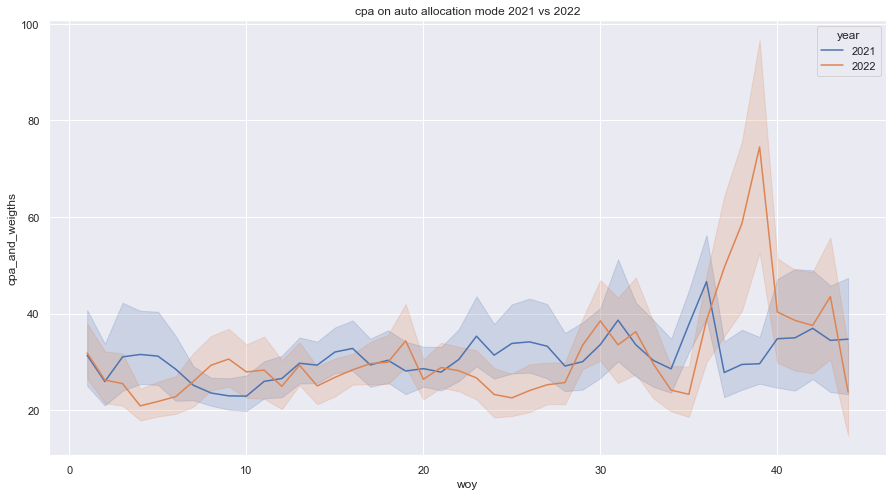

In [115]:
dfaflg["year"]="2022"
# dfflg_auto1 =dfoflg[dfoflg.conv_seg==True]
dfoflg["year"]="2021"
dfflg_auto = pd.concat([dfoflg, dfaflg])
dfflg_auto.reset_index(drop=True, inplace=True)

sns.lineplot(x='woy', y='cpa_and_weigths', data=dfflg_auto[(dfflg_auto.conv_seg==True)&(dfflg_auto.auto_allocation_mode=='true')&(dfflg_auto.auto_allocation_mode=='true')], hue='year',estimator=weighted_mean).set(title="cpa on auto allocation mode 2021 vs 2022")
plt.show()


In [121]:
print("cpa 2022 on auto mode group",dfflg_auto[(dfflg_auto.conv_seg==True)&(dfflg_auto.year=="2022")&(dfflg_auto.auto_allocation_mode=='true')].cost_flg.sum()/dfflg_auto[(dfflg_auto.conv_seg==True)&(dfflg_auto.year=="2022")&(dfflg_auto.auto_allocation_mode=='true')].conv_flg.sum())
print("cpa 2021 on auto mode group",dfflg_auto[(dfflg_auto.conv_seg==True)&(dfflg_auto.year=="2021")&(dfflg_auto.auto_allocation_mode=='true')].cost_flg.sum()/dfflg_auto[(dfflg_auto.conv_seg==True)&(dfflg_auto.year=="2021")&(dfflg_auto.auto_allocation_mode=='true')].conv_flg.sum())




cpa 2022 on auto mode group 30.796332913374385
cpa 2021 on auto mode group 31.58579618360635


In [125]:
dfflg_auto

customer_id  flight_id  conv_seg   woy  ac_flg  conv_flg     cost_flg  \
0               29       4436     False  21.0     2.0       0.0     0.000000   
1               29       4436      True  21.0   738.0     101.0  3286.109564   
2               29       4436     False  22.0     4.0       1.0     0.000000   
3               29       4436      True  22.0   790.0      95.0  2821.921614   
4               29       4436     False  23.0     2.0       1.0     0.000000   
...            ...        ...       ...   ...     ...       ...          ...   
46098     12341234      10588      True  40.0  1052.0     102.0   382.660000   
46099     12341234      10588      True  41.0   835.0      94.0   603.680000   
46100     12341234      10588      True  42.0   736.0      67.0   520.220000   
46101     12341234      10588      True  43.0   391.0      37.0   302.740000   
46102     12341234      10588      True  44.0     0.0       0.0     0.200000   

       board_percentage_indeed  board_percentage_adwords auto_allocation_mode  \
0                     0.000000                       NaN                 true   
1                     0.000000                       NaN                 true   
2                     0.000000                       NaN                 true   
3                     0.000000                       NaN                 true   
4                     0.000000                       NaN                 true   
...                        ...                       ...                  ...   
46098                 1.036364                       NaN                false   
46099                 1.036364                       NaN                false   
46100                 1.036364                       NaN                false   
46101                 1.007497                       NaN                false   
46102                 0.920000                       NaN                false   

             cpa      cpac        cpa_and_weigths       cpac_and_weigths  year  
0       0.000000  0.000000     0.000000+0.000000j     0.000000+2.000000j  2021  
1      32.535738  4.452723  32.535738+101.000000j   4.452723+738.000000j  2021  
2       0.000000  0.000000     0.000000+1.000000j     0.000000+4.000000j  2021  
3      29.704438  3.572053   29.704438+95.000000j   3.572053+790.000000j  2021  
4       0.000000  0.000000     0.000000+1.000000j     0.000000+2.000000j  2021  
...          ...       ...                    ...                    ...   ...  
46098   3.751569  0.363745   3.751569+102.000000j  0.363745+1052.000000j  2022  
46099   6.422128  0.722970    6.422128+94.000000j   0.722970+835.000000j  2022  
46100   7.764478  0.706821    7.764478+67.000000j   0.706821+736.000000j  2022  
46101   8.182162  0.774271    8.182162+37.000000j   0.774271+391.000000j  2022  
46102   0.200000  0.200000     0.200000+0.000000j     0.200000+0.000000j  2022  

[46103 rows x 15 columns]

In [126]:
dfflg_auto.columns

Index(['customer_id', 'flight_id', 'conv_seg', 'woy', 'ac_flg', 'conv_flg',
       'cost_flg', 'board_percentage_indeed', 'board_percentage_adwords',
       'auto_allocation_mode', 'cpa', 'cpac', 'cpa_and_weigths',
       'cpac_and_weigths', 'year'],
      dtype='object')

In [147]:
dfflg_auto[dfflg_auto.conv_seg].cost_flg.sum() / dfflg_auto.cost_flg.sum()

0.10067979372313524

In [151]:
dflgp=dfflg_auto[[
#     'customer_id',
    'conv_seg',     
    'auto_allocation_mode', 
    'year',
     'woy', 
     'ac_flg', 
     'conv_flg',
    'cost_flg', 
]].groupby([ 
#     'customer_id',
    'conv_seg',     
    'auto_allocation_mode', 
    'year',
     'woy',
]).sum().reset_index()

    
dflgp["q"] = dflgp.woy.apply(lambda woy: math.floor(1 + (woy/13)))

dflgp["cpa"] = dflgp["cost_flg"]  / dflgp["conv_flg"] 
dflgp.loc[dflgp["conv_flg"] ==0, "cpa"] = dflgp["cost_flg"] 
dflgp["cpac"] = dflgp["cost_flg"]  / dflgp["ac_flg"] 
dflgp.loc[dflgp["ac_flg"] ==0, "cpac"] = dflgp["cost_flg"] 

dflgp["cpa_and_weigths"] =  [ v + w*1j for v,w in zip(dflgp.cpa, dflgp.conv_flg)]
dflgp

conv_seg auto_allocation_mode  year   woy    ac_flg  conv_flg  \
0       False                false  2021   1.0    7613.0       0.0   
1       False                false  2021   2.0    7419.0       0.0   
2       False                false  2021   3.0    8695.0       0.0   
3       False                false  2021   4.0   10878.0       0.0   
4       False                false  2021   5.0   17114.0       0.0   
..        ...                  ...   ...   ...       ...       ...   
347      True                 true  2022  40.0  180273.0   22824.0   
348      True                 true  2022  41.0  141123.0   18165.0   
349      True                 true  2022  42.0  152871.0   19611.0   
350      True                 true  2022  43.0  147219.0   18749.0   
351      True                 true  2022  44.0   36164.0    4694.0   

          cost_flg  q           cpa      cpac          cpa_and_weigths  
0     16099.190000  1  16099.190000  2.114697   16099.190000+0.000000j  
1     20446.770000  1  20446.770000  2.756001   20446.770000+0.000000j  
2     14589.820000  1  14589.820000  1.677955   14589.820000+0.000000j  
3     14676.890000  1  14676.890000  1.349227   14676.890000+0.000000j  
4     24112.150000  1  24112.150000  1.408914   24112.150000+0.000000j  
..             ... ..           ...       ...                      ...  
347  923368.173443  4     40.456019  5.122055  40.456019+22824.000000j  
348  706756.627583  4     38.907604  5.008090  38.907604+18165.000000j  
349  748177.209906  4     38.150895  4.894174  38.150895+19611.000000j  
350  822073.647970  4     43.846266  5.584019  43.846266+18749.000000j  
351  112386.394028  4     23.942564  3.107687   23.942564+4694.000000j  

[352 rows x 11 columns]

In [159]:
dflgpcomp = dflgp[dflgp.auto_allocation_mode=='true'].merge(dflgp[dflgp.auto_allocation_mode=='false'], on=[
    "year", "woy", "conv_seg","q"], suffixes=["_auto","_manual"])

In [160]:
# dflgpcomp[(dflgpcomp.conv_seg)&()].cost_flg_auto.sum()

conv_seg auto_allocation_mode_auto  year   woy  ac_flg_auto  \
0       False                      true  2021   1.0        279.0   
1       False                      true  2021   2.0        423.0   
2       False                      true  2021   3.0        547.0   
3       False                      true  2021   4.0        430.0   
4       False                      true  2021   5.0        367.0   
..        ...                       ...   ...   ...          ...   
171      True                      true  2022  40.0     180273.0   
172      True                      true  2022  41.0     141123.0   
173      True                      true  2022  42.0     152871.0   
174      True                      true  2022  43.0     147219.0   
175      True                      true  2022  44.0      36164.0   

     conv_flg_auto  cost_flg_auto  q     cpa_auto  cpac_auto  \
0              0.0    2732.494713  1  2732.494713   9.793888   
1              0.0    2267.648708  1  2267.648708   5.360872   
2              0.0    3714.638175  1  3714.638175   6.790929   
3              0.0    2193.831765  1  2193.831765   5.101934   
4              0.0    1538.933883  1  1538.933883   4.193280   
..             ...            ... ..          ...        ...   
171        22824.0  923368.173443  4    40.456019   5.122055   
172        18165.0  706756.627583  4    38.907604   5.008090   
173        19611.0  748177.209906  4    38.150895   4.894174   
174        18749.0  822073.647970  4    43.846266   5.584019   
175         4694.0  112386.394028  4    23.942564   3.107687   

        cpa_and_weigths_auto auto_allocation_mode_manual  ac_flg_manual  \
0      2732.494713+0.000000j                       false         7613.0   
1      2267.648708+0.000000j                       false         7419.0   
2      3714.638175+0.000000j                       false         8695.0   
3      2193.831765+0.000000j                       false        10878.0   
4      1538.933883+0.000000j                       false        17114.0   
..                       ...                         ...            ...   
171  40.456019+22824.000000j                       false       284520.0   
172  38.907604+18165.000000j                       false       266053.0   
173  38.150895+19611.000000j                       false       305392.0   
174  43.846266+18749.000000j                       false       331753.0   
175   23.942564+4694.000000j                       false        77549.0   

     conv_flg_manual  cost_flg_manual    cpa_manual  cpac_manual  \
0                0.0     1.609919e+04  16099.190000     2.114697   
1                0.0     2.044677e+04  20446.770000     2.756001   
2                0.0     1.458982e+04  14589.820000     1.677955   
3                0.0     1.467689e+04  14676.890000     1.349227   
4                0.0     2.411215e+04  24112.150000     1.408914   
..               ...              ...           ...          ...   
171          51334.0     1.583307e+06     30.843244     5.564836   
172          47718.0     1.534236e+06     32.152146     5.766656   
173          55300.0     1.588716e+06     28.729037     5.202218   
174          54507.0     1.717044e+06     31.501351     5.175670   
175          12631.0     2.190139e+05     17.339392     2.824200   

      cpa_and_weigths_manual  
0     16099.190000+0.000000j  
1     20446.770000+0.000000j  
2     14589.820000+0.000000j  
3     14676.890000+0.000000j  
4     24112.150000+0.000000j  
..                       ...  
171  30.843244+51334.000000j  
172  32.152146+47718.000000j  
173  28.729037+55300.000000j  
174  31.501351+54507.000000j  
175  17.339392+12631.000000j  

[176 rows x 18 columns]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in double_scalars



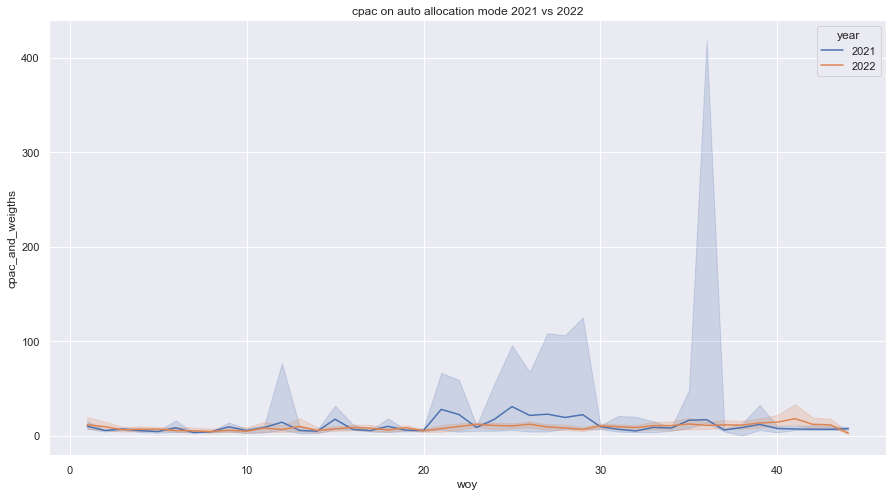

In [117]:
sns.lineplot(x='woy', y='cpac_and_weigths', data=dfflg_auto[(dfflg_auto.conv_seg==False)&(dfflg_auto.auto_allocation_mode=='true')], hue='year',estimator=weighted_mean).set(title="cpac on auto allocation mode 2021 vs 2022")
plt.show()


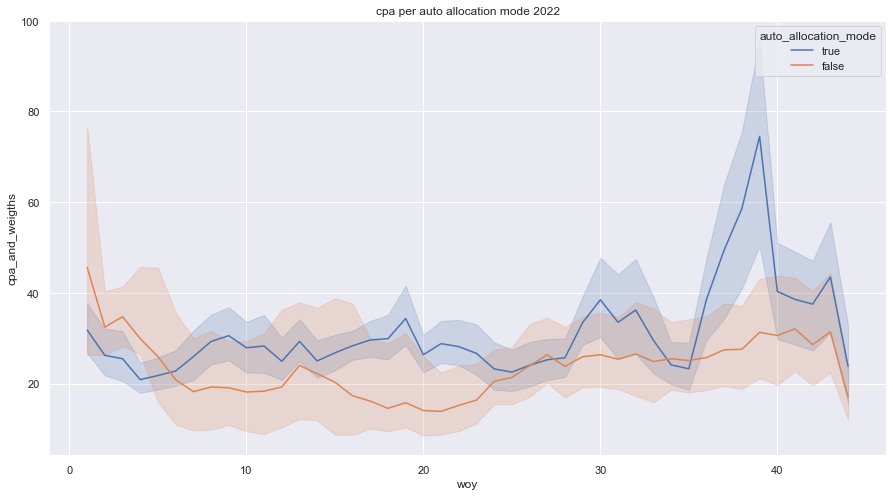

In [92]:


sns.lineplot(x='woy', y='cpa_and_weigths', data=dfaflg[dfaflg.conv_seg==True], hue='auto_allocation_mode',estimator=weighted_mean).set(title="cpa per auto allocation mode 2022")
plt.show()


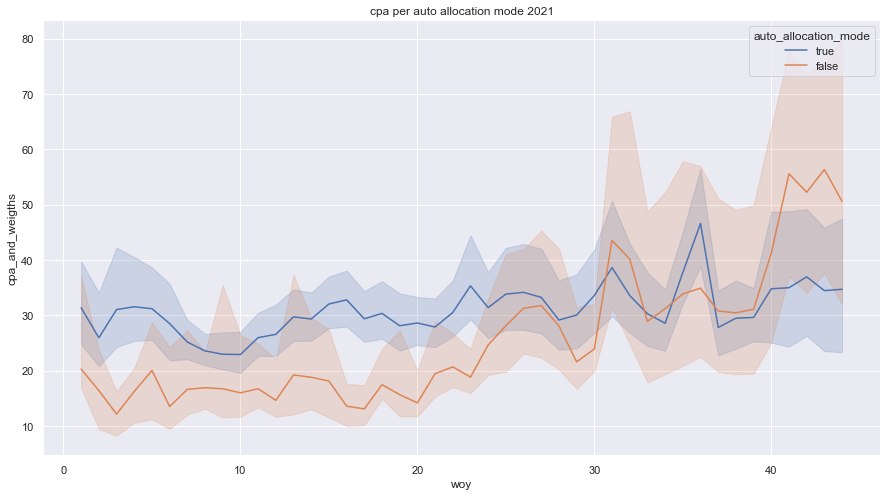

In [93]:

sns.lineplot(x='woy', y='cpa_and_weigths', data=dfoflg[dfoflg.conv_seg==True], hue='auto_allocation_mode',estimator=weighted_mean).set(title="cpa per auto allocation mode 2021")
plt.show()

In [53]:
df_all = df_mdjs.merge(df_flg_hist_w, on=["customer_id", "flight_id", "board_group", "woy"], how="left")
df_all = df_all.merge(df_flglvl, on=["customer_id", "flight_id","conv_seg", "woy"])
df_all = df_all[df_all.woy > 0].reset_index(drop=True)
df_all= df_all[df_all.flight_id >=0]

df_all.auto_allocation_mode.fillna('false', inplace=True)
# df_all.auto_allocation_mode.fillna('none', inplace=True)

In [54]:
df_all.auto_allocation_mode.isna().sum(), len(df_all)

(0, 65660)

In [55]:
df_all[df_all.auto_allocation_mode.isna()]

Empty DataFrame
Columns: [customer_id, flight_id, board_group, woy, conv_seg, job_count, apply_clicks, conversions, clicks, cost, board_percentage, auto_allocation_mode, auto_allocation_mode_l, jb_count_flg, conv_flg, cost_flg]
Index: []

In [56]:
df_all.auto_allocation_mode.value_counts()

false    50204
true     15456
Name: auto_allocation_mode, dtype: int64

In [57]:
df_all_gp = df_all[
["auto_allocation_mode", "woy", "conv_seg","board_group","job_count","conversions","cost",
    "jb_count_flg","conv_flg","cost_flg"
]
].groupby(["board_group", "auto_allocation_mode", "conv_seg","woy"]).sum().reset_index().sort_values(["board_group", "woy"])

df_all_gp["cpa"] = df_all_gp["cost"] / df_all_gp["conversions"]
df_all_gp["cpj"] = df_all_gp["cost"] / df_all_gp["job_count"]
df_all_gp["cpa_flg"] = df_all_gp["cost_flg"] / df_all_gp["conv_flg"]
df_all_gp["cpj_flg"] = df_all_gp["cost_flg"] / df_all_gp["jb_count_flg"]
df_all_gp["cpa_other"] =  (df_all_gp["cost_flg"]  - df_all_gp["cost"] )/(df_all_gp["conv_flg"]  - df_all_gp["conversions"] )
df_all_gp["board_share"] = df_all_gp["cost"] / df_all_gp["cost_flg"]
df_all_gp.to_csv("autoalloc_week.csv")

In [58]:
df_old = df_mdjs_last_year.merge(df_flg_hist_w, on=["customer_id", "flight_id", "board_group", "woy"], how="left")
df_old=df_old.merge(df_flglvl_old, on=["customer_id", "flight_id","conv_seg", "woy"])
df_old = df_old[df_old.woy > 5].reset_index(drop=True)


df_old.auto_allocation_mode.fillna('false', inplace=True)
# df_all.auto_allocation_mode.fillna('none', inplace=True)
df_old_gp = df_old[
["auto_allocation_mode", "woy","conv_seg", "board_group","job_count","conversions","cost",
    "jb_count_flg","conv_flg","cost_flg"
]
].groupby(["board_group", "auto_allocation_mode","conv_seg", "woy"]).sum().reset_index().sort_values(["board_group", "woy"])
df_old_gp["cpa"] = df_old_gp["cost"] / df_old_gp["conversions"]
df_old_gp["cpj"] = df_old_gp["cost"] / df_old_gp["job_count"]
df_old_gp["cpa_flg"] = df_old_gp["cost_flg"] / df_old_gp["conv_flg"]
df_old_gp["cpj_flg"] = df_old_gp["cost_flg"] / df_old_gp["jb_count_flg"]
df_old_gp["board_share"] = df_old_gp["cost"] / df_old_gp["cost_flg"]
# df_old_gp.auto_allocation_mode.fillna('none', inplace=True)
df_old_gp["cpa_other"] = (df_old_gp["cost_flg"]  - df_old_gp["cost"] )/(df_old_gp["conv_flg"]  - df_old_gp["conversions"] )

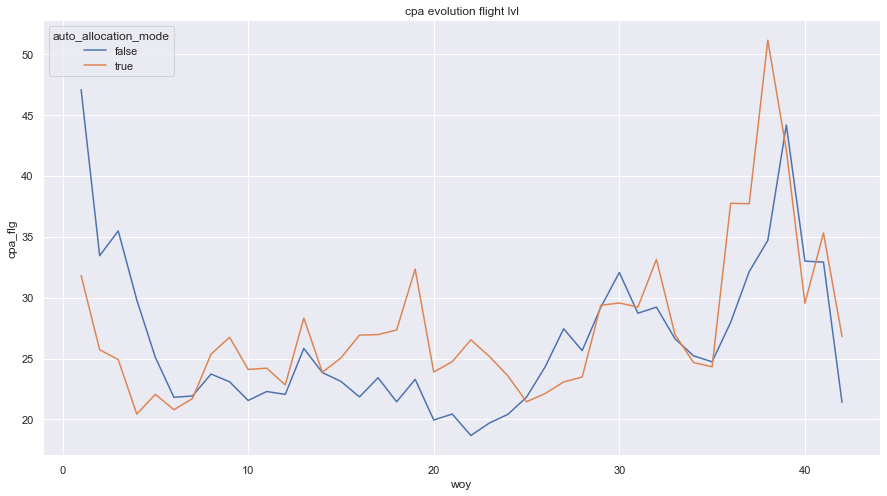

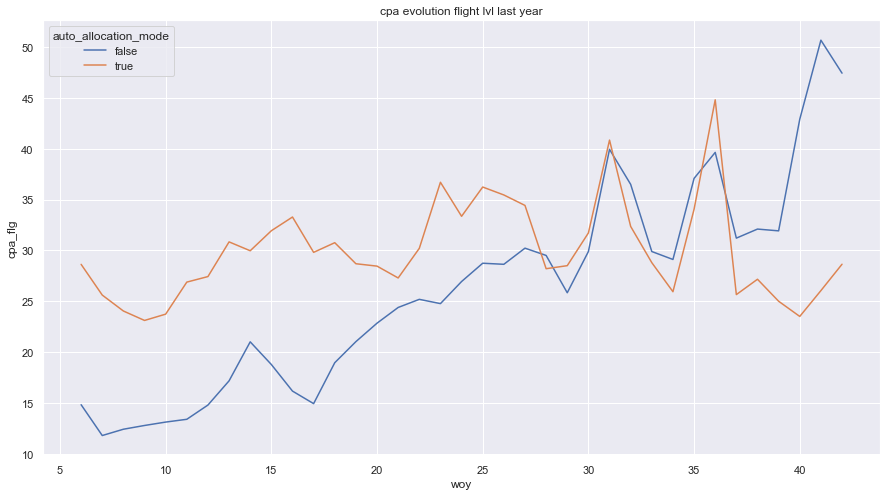

In [59]:
b = "indeed"
# px.line(df_all_gp[df_all_gp.board_group==b], x="woy", y="cpa_flg", color="auto_allocation_mode", title="cpa evolution flight lvl")
sns.lineplot(x='woy', y='cpa_flg', data=df_all_gp[
    (df_all_gp.board_group==b)&(df_all_gp.conv_seg)
], hue='auto_allocation_mode').set_title("cpa evolution flight lvl")
plt.show()

b = "indeed"
sns.lineplot(x='woy', y='cpa_flg', data=df_old_gp[    (df_old_gp.board_group==b)&(df_old_gp.conv_seg)], hue='auto_allocation_mode').set_title("cpa evolution flight lvl last year")
# px.line(df_old_gp[df_old_gp.board_group==b], x="woy", y="cpa_flg", color="auto_allocation_mode", title="cpa evolution flight lvl last year")
plt.show()

# To present 2021 vs 2022 on auto allocated flights

In [103]:
# dfcomp=pd.DataFrame(columns =["woy","cpa_flg_2021","cpa_flg_2022"])
dfc1 = df_all_gp[
    (df_all_gp.board_group==b)&(df_all_gp.conv_seg)&(df_all_gp.auto_allocation_mode=='true')
][["woy","cpa_flg","cost_flg","conv_flg"]]
dfc2 = df_old_gp[(df_old_gp.board_group==b)&(df_old_gp.conv_seg)&(df_old_gp.auto_allocation_mode=='true')
][["woy","cpa_flg","cost_flg","conv_flg"]]
dfc1["year"]="2022"
dfc2["year"]="2021"

dfc= pd.concat([dfc1,dfc2])
# dfcomp = dfc1.merge(dfc2, on=["woy"], how="outer",suffixes=["_2022", "_2021"])
# dfcomp

sns.lineplot(x='woy', y='cpa_flg', data=dfc
, hue='year')


plt.show()


In [102]:
(
    dfc[dfc["year"]=="2022"]["cost_flg"].sum()/dfc[dfc["year"]=="2022"]["conv_flg"].sum(),
    dfc[dfc["year"]=="2021"]["cost_flg"].sum()/dfc[dfc["year"]=="2021"]["conv_flg"].sum())

(26.100864402260264, 29.028018039553714)

In [106]:
# dfcomp=pd.DataFrame(columns =["woy","cpa_flg_2021","cpa_flg_2022"])
dfc1b = df_all_gp[
    (df_all_gp.board_group==b)&(df_all_gp.conv_seg)&(df_all_gp.auto_allocation_mode=='false')
][["woy","cpa_flg","cost_flg","conv_flg"]]
dfc2b = df_old_gp[(df_old_gp.board_group==b)&(df_old_gp.conv_seg)&(df_old_gp.auto_allocation_mode=='false')
][["woy","cpa_flg","cost_flg","conv_flg"]]
dfc1b["year"]="2022"
dfc2b["year"]="2021"

dfcb= pd.concat([dfc1b,dfc2b])
dfcomp = dfc.merge(dfcb, on=["woy", "year"], how="outer",suffixes=["_auto", "_manual"])
dfcomp

# sns.lineplot(x='woy', y='cpa_flg', data=dfc , hue='year')


# plt.show()

woy  cpa_flg_auto  cost_flg_auto  conv_flg_auto  year  cpa_flg_manual  \
0    1.0     31.802574   1.008428e+06        31709.0  2022       47.057985   
1    2.0     25.718593   7.312567e+05        28433.0  2022       33.430744   
2    3.0     24.912597   7.204225e+05        28918.0  2022       35.469367   
3    4.0     20.443748   6.374974e+05        31183.0  2022       29.807242   
4    5.0     22.061239   6.800597e+05        30826.0  2022       25.094169   
..   ...           ...            ...            ...   ...             ...   
74  38.0     27.171141   4.534320e+05        16688.0  2021       32.101532   
75  39.0     25.010892   4.140303e+05        16554.0  2021       31.926324   
76  40.0     23.518069   4.707142e+05        20015.0  2021       42.890505   
77  41.0     26.054360   5.170488e+05        19845.0  2021       50.660957   
78  42.0     28.647156   3.609542e+05        12600.0  2021       47.420347   

    cost_flg_manual  conv_flg_manual  
0      3.788168e+04            805.0  
1      2.943243e+05           8804.0  
2      3.214234e+05           9062.0  
3      7.398456e+05          24821.0  
4      8.181703e+05          32604.0  
..              ...              ...  
74     6.417738e+05          19992.0  
75     7.368276e+05          23079.0  
76     1.126991e+06          26276.0  
77     1.467192e+06          28961.0  
78     8.946323e+05          18866.0  

[79 rows x 8 columns]

In [109]:
dfcomp["delta"] = dfcomp["cpa_flg_manual"] - dfcomp["cpa_flg_auto"]

sns.lineplot(x='woy', y='delta', data=dfcomp , hue='year')

<AxesSubplot:xlabel='woy', ylabel='delta'>

In [114]:
(
    dfcomp[dfcomp["year"]=="2022"]["cost_flg_manual"].sum() / dfcomp[dfcomp["year"]=="2022"]["conv_flg_manual"].sum()-
    dfcomp[dfcomp["year"]=="2022"]["cost_flg_auto"].sum() / dfcomp[dfcomp["year"]=="2022"]["conv_flg_auto"].sum()
     ,
    dfcomp[dfcomp["year"]=="2021"]["cost_flg_manual"].sum() / dfcomp[dfcomp["year"]=="2021"]["conv_flg_manual"].sum()-
    dfcomp[dfcomp["year"]=="2021"]["cost_flg_auto"].sum() / dfcomp[dfcomp["year"]=="2021"]["conv_flg_auto"].sum()
)

(0.05267988154131942, -1.0112980589317075)

In [115]:
(
    dfcomp[dfcomp["year"]=="2022"]["cost_flg_manual"].sum() / dfcomp[dfcomp["year"]=="2022"]["conv_flg_manual"].sum(),
    dfcomp[dfcomp["year"]=="2022"]["cost_flg_auto"].sum() / dfcomp[dfcomp["year"]=="2022"]["conv_flg_auto"].sum()
     ,
    dfcomp[dfcomp["year"]=="2021"]["cost_flg_manual"].sum() / dfcomp[dfcomp["year"]=="2021"]["conv_flg_manual"].sum(),
    dfcomp[dfcomp["year"]=="2021"]["cost_flg_auto"].sum() / dfcomp[dfcomp["year"]=="2021"]["conv_flg_auto"].sum()
)

(26.153544283801583,
 26.100864402260264,
 28.016719980622007,
 29.028018039553714)

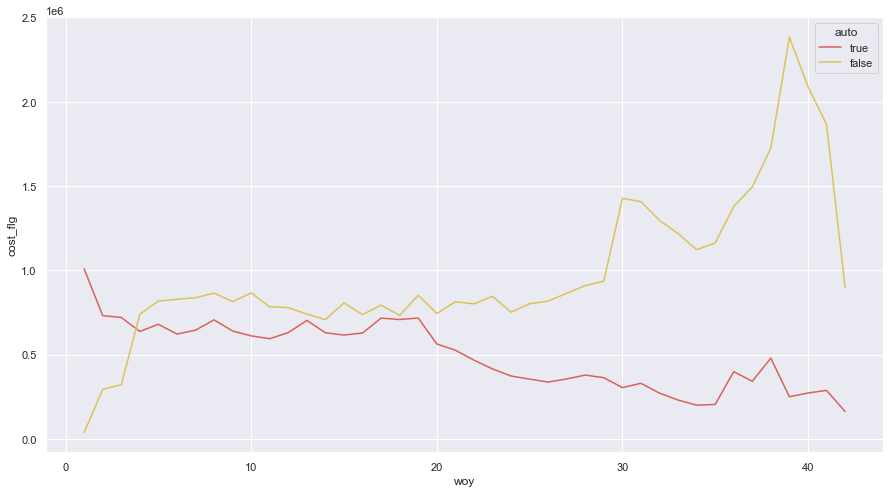

In [116]:
# dfcomp=pd.DataFrame(columns =["woy","cpa_flg_2021","cpa_flg_2022"])
dfc1c = df_all_gp[
    (df_all_gp.board_group==b)&(df_all_gp.conv_seg)&(df_all_gp.auto_allocation_mode=='true')
][["woy","cpa_flg","cost_flg","conv_flg"]]
dfc2c = df_all_gp[
    (df_all_gp.board_group==b)&(df_all_gp.conv_seg)&(df_all_gp.auto_allocation_mode=='false')
][["woy","cpa_flg","cost_flg","conv_flg"]]
dfc1c["auto"]="true"
dfc2c["auto"]="false"

dfcc= pd.concat([dfc1c,dfc2c])
# dfcomp = dfc1.merge(dfc2, on=["woy"], how="outer",suffixes=["_2022", "_2021"])
# dfcomp

sns.lineplot(x='woy', y='cost_flg', data=dfcc
, hue='auto')


plt.show()


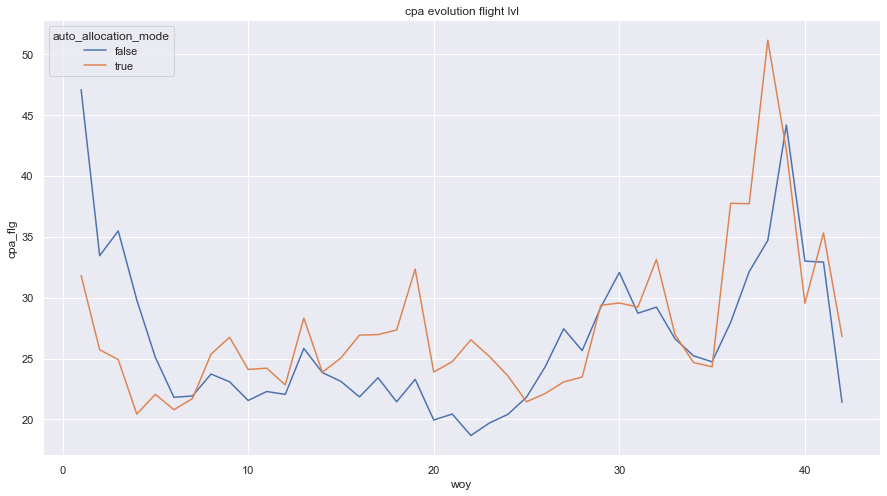

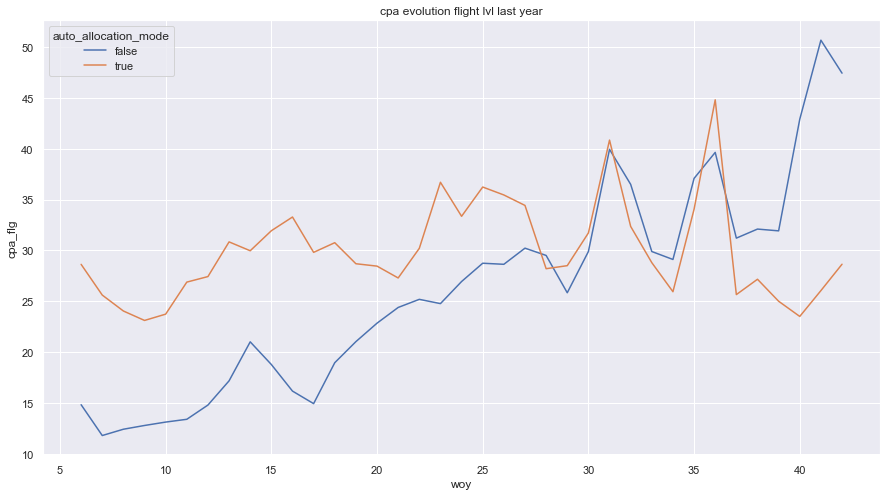

In [61]:
b = "indeed"
# px.line(df_all_gp[df_all_gp.board_group==b], x="woy", y="cpa_flg", color="auto_allocation_mode", title="cpa evolution flight lvl")
sns.lineplot(x='woy', y='cpa_flg', data=df_all_gp[(df_all_gp.board_group==b)&(df_all_gp.conv_seg)], hue='auto_allocation_mode').set_title("cpa evolution flight lvl")
plt.show()

b = "indeed"
sns.lineplot(x='woy', y='cpa_flg', data=df_old_gp[(df_old_gp.board_group==b)&(df_old_gp.conv_seg)], hue='auto_allocation_mode').set_title("cpa evolution flight lvl last year")
# px.line(df_old_gp[df_old_gp.board_group==b], x="woy", y="cpa_flg", color="auto_allocation_mode", title="cpa evolution flight lvl last year")
plt.show()

cpa indeed more a little divergent between auto mode group and the manual mode group this year than last

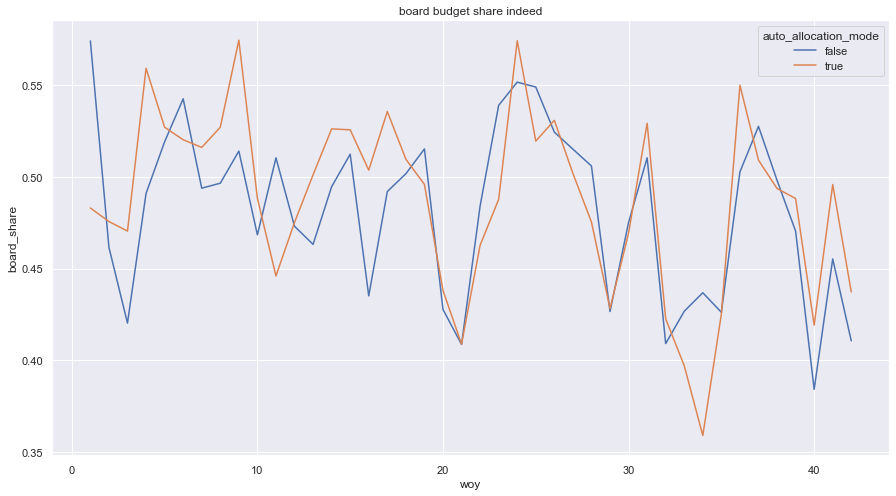

Text(0.5, 1.0, 'board budget share indeed')

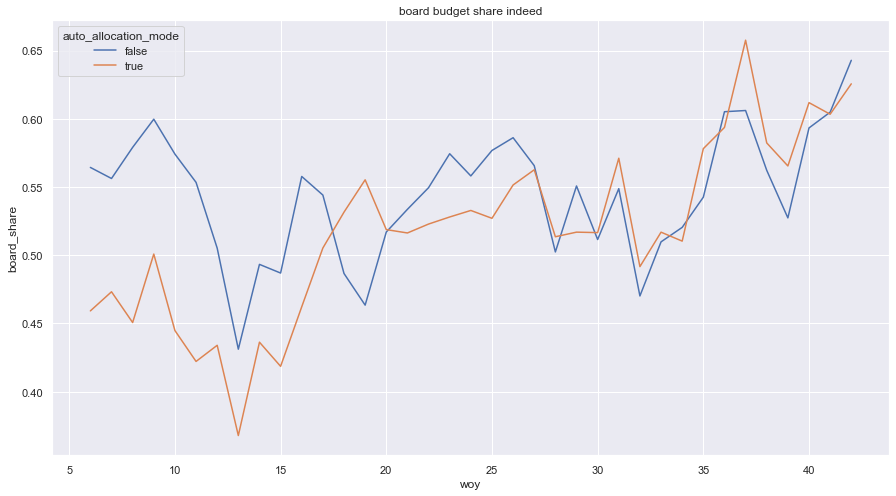

In [31]:
b = "indeed"
# px.line(df_all_gp[df_all_gp.board_group==b], x="woy", y="board_share", color="auto_allocation_mode", title="board budget share indeed")

sns.lineplot(x='woy', y='board_share', data=df_all_gp[(df_all_gp.board_group==b)&(df_all_gp.conv_seg)], hue='auto_allocation_mode').set_title("board budget share indeed")
plt.show()
# b = "indeed"
sns.lineplot(x='woy', y='board_share', data=df_old_gp[(df_old_gp.board_group==b)&(df_old_gp.conv_seg)], hue='auto_allocation_mode').set_title("board budget share indeed")
# # px.line(df_old_gp[df_old_gp.board_group==b], x="woy", y="cpa_flg", color="auto_allocation_mode", title="cpa evolution flight lvl last year")
# plt.show()

the share given to indeed seems equivalent for both modes

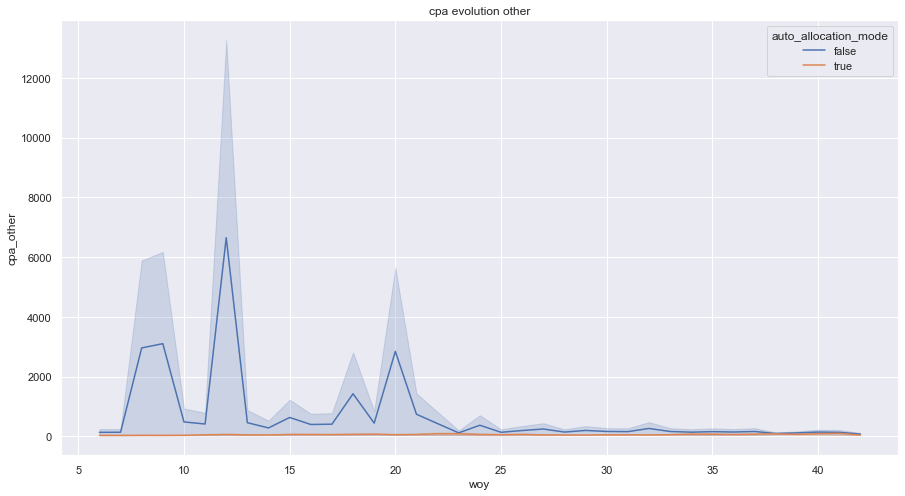

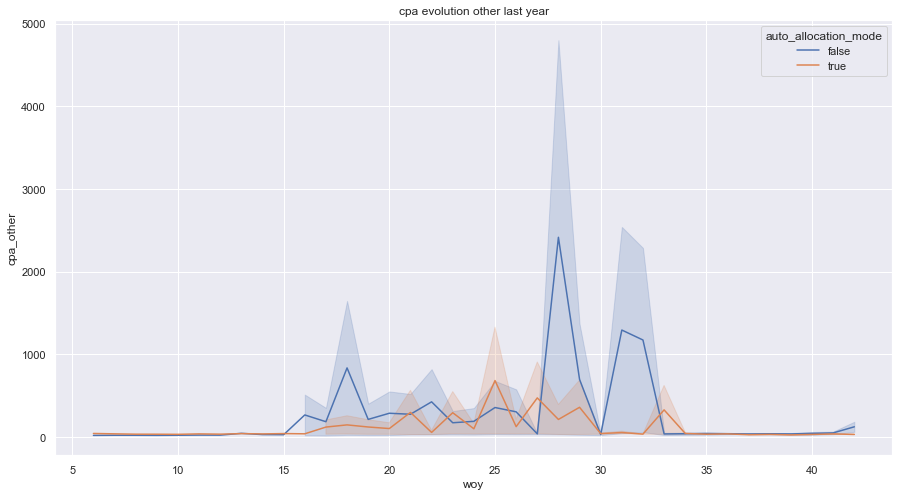

In [62]:
b = "indeed"
# px.line(df_all_gp[df_all_gp.board_group==b], x="woy", y="cpa_other", color="auto_allocation_mode", title="cpa evolution other")


sns.lineplot(x='woy', y='cpa_other', data=df_all_gp[df_all_gp.board_group==b], hue='auto_allocation_mode').set_title("cpa evolution other")
plt.show()

sns.lineplot(x='woy', y='cpa_other', data=df_old_gp[df_old_gp.board_group==b], hue='auto_allocation_mode').set_title("cpa evolution other last year")
# px.line(df_old_gp[df_old_gp.board_group==b], x="woy", y="cpa_flg", color="auto_allocation_mode", title="cpa evolution flight lvl last year")
plt.show()



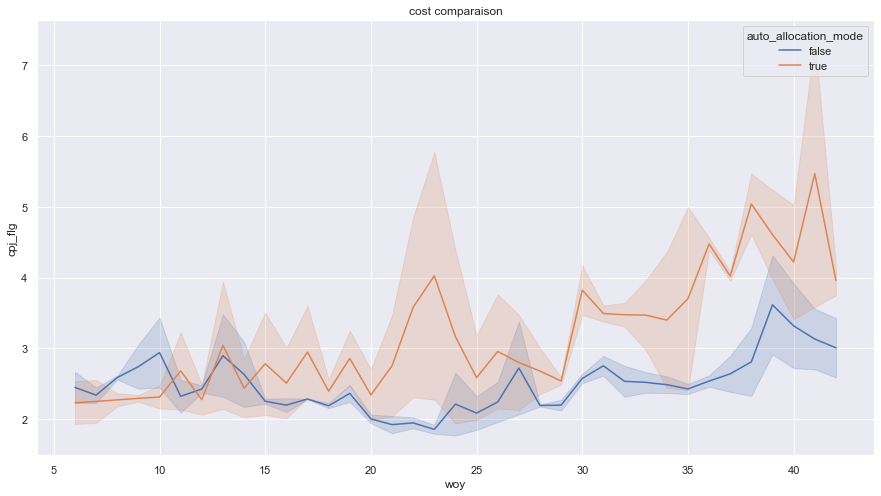

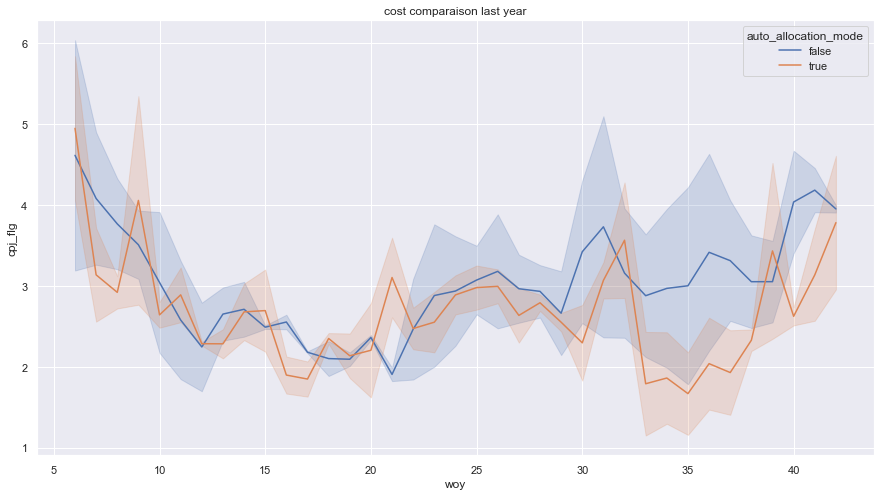

In [63]:
b = "indeed"
# px.line(df_all_gp[df_all_gp.board_group==b], x="woy", y="cpj_flg", color="auto_allocation_mode", title="cost comparaison")


sns.lineplot(x='woy', y='cpj_flg', data=df_all_gp[df_all_gp.board_group==b], hue='auto_allocation_mode').set_title("cost comparaison")
plt.show()

sns.lineplot(x='woy', y='cpj_flg', data=df_old_gp[df_old_gp.board_group==b], hue='auto_allocation_mode').set_title("cost comparaison last year")
# px.line(df_old_gp[df_old_gp.board_group==b], x="woy", y="cpa_flg", color="auto_allocation_mode", title="cpa evolution flight lvl last year")
plt.show()




In [32]:


q = """
select
    
    case
    when job_board in ('jb_indeed', 'jb_indeed_eur', 'jb_indeed_gbp')
        then 'indeed'
    else 'adwords'
    end as board_group,
    mdjs.date, conv_seg,
    extract(week from mdjs.date )as woy,
   sum(conversions_p) as conv,sum(applyclicks_p) as ap, sum(cost) as cost
from panther.master_detailed_job_stats mdjs
join (
    select id as segment_id, customer_id, objectives->>'lifetime_ecpa_a_p' is not null as conv_seg
    from panther.filters
    where filter_type_id=2

) seg on mdjs.segment_id=seg.segment_id and mdjs.customer_id=seg.customer_id
where date >='2020-01-01'
and flight_id != -1
group by 1,2,3,4
order by 1,2,3,4;
"""

dfglobal = pd.read_sql(q, pg_engine)
dfglobal["year"] = pd.to_datetime(dfglobal["date"]).dt.year
dfglobal["woyn"] =  (dfglobal["woy"] * 2).astype(int).astype(str)
dfglobal.loc[dfglobal.woy<5,"woyn"] = "0" +  dfglobal["woyn"]
dfglobal["time"] = (dfglobal["year"].astype(int).astype(str) + "" + dfglobal["woyn"]).astype(int)



dfglobalweek =  dfglobal.groupby(["board_group","year","woy", "conv_seg"]).aggregate({
    "conv":sum,
    "ap":sum,
    "cost":sum,
    "date": "first"
})
dfglobalweek.reset_index(inplace=True)
# dfglobalweek

dfglobalgp = dfglobal.groupby(["conv_seg","year","woy",]).aggregate({
    "conv":sum,
    "ap":sum,
    "cost":sum,
    "date": "first"
})
dfglobalgp.reset_index(inplace=True)
dfglobalgp


def add_metrix_to_global(df):
    df["cpa"] = df["cost"]/df["conv"]
    df.loc[df.conv==0,"cpa"] = df["cost"]
    df["cpac"] = df["cost"]/df["ap"]
    df.loc[df.ap==0,"cpac"] = df["ap"]
   
def plot_global(df, metrix='cpa'):
    if 'board_group' in df.columns:
        sns.lineplot(x='date', y=metrix, data=df, hue='board_group').set(title="cpa evolution")
    else:
        sns.lineplot(x='date', y=metrix, data=df).set(title="cpa evolution")
#     plt.bar(30, 30, width=0.1)
    plt.xticks(rotation=90)
#     plt.xlim(18,max_week)
    plt.show()
    
    
    
add_metrix_to_global(dfglobalweek)
add_metrix_to_global(dfglobalgp)
    

In [35]:
dfglobalweek

board_group  year   woy  conv_seg     conv        ap           cost  \
0       adwords  2020   1.0     False    212.0    1140.0   15467.147286   
1       adwords  2020   1.0      True   3234.0    9481.0   67333.677446   
2       adwords  2020   2.0     False    418.0    2333.0   36126.819353   
3       adwords  2020   2.0      True   4366.0   12294.0  136377.627112   
4       adwords  2020   3.0     False    461.0    2998.0   38751.896400   
..          ...   ...   ...       ...      ...       ...            ...   
591      indeed  2022  41.0      True  42754.0  228761.0  994567.510000   
592      indeed  2022  42.0     False    474.0   25941.0   56497.256550   
593      indeed  2022  42.0      True  32999.0  177804.0  441644.676781   
594      indeed  2022  52.0     False      2.0    5482.0   21963.980000   
595      indeed  2022  52.0      True   1789.0    6513.0   66239.021156   

           date           cpa       cpac  
0    2020-01-01     72.958242  13.567673  
1    2020-01-01     20.820556   7.101959  
2    2020-01-06     86.427797  15.485135  
3    2020-01-06     31.236287  11.093023  
4    2020-01-13     84.060513  12.925916  
..          ...           ...        ...  
591  2022-10-10     23.262560   4.347627  
592  2022-10-17    119.192524   2.177914  
593  2022-10-17     13.383578   2.483885  
594  2022-01-01  10981.990000   4.006563  
595  2022-01-01     37.025725  10.170278  

[596 rows x 10 columns]

2020 adwords 20.27427938839426
2020 indeed 14.98142881474685
2021 adwords 32.279272548538245
2021 indeed 26.03414018944729
2022 adwords 40.42745487354566
2022 indeed 19.14570408048472


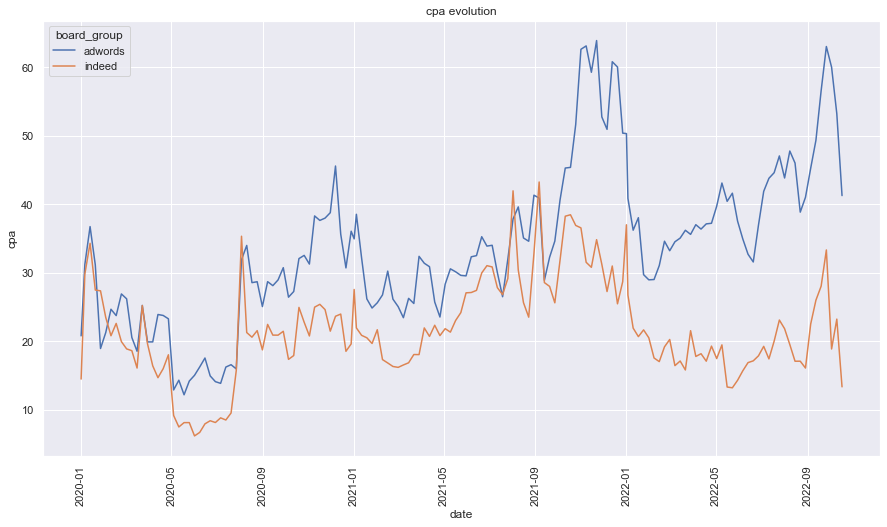

In [37]:
for y in range(2020, 2023):
    for b in ["adwords", "indeed"]:
        print(y, b,
            dfglobalweek[(dfglobalweek.woy<43)&(dfglobalweek.conv_seg==True)&(dfglobalweek.year == y)&(dfglobalweek.board_group == b)].cost.sum()/
            dfglobalweek[(dfglobalweek.woy<43)&(dfglobalweek.conv_seg==True)&(dfglobalweek.year == y)&(dfglobalweek.board_group == b)].conv.sum()
        )
plot_global(dfglobalweek[dfglobalweek.conv_seg==True])

In [40]:
df_all_gp

board_group auto_allocation_mode  conv_seg   woy  job_count  conversions  \
0       adwords                false     False   1.0          2          2.0   
31      adwords                false      True   1.0        460         96.0   
105     adwords                 true      True   1.0       1600         64.0   
32      adwords                false      True   2.0        508        127.0   
73      adwords                 true     False   2.0          1          1.0   
..          ...                  ...       ...   ...        ...          ...   
396       other                false      True  40.0     438695      25704.0   
355       other                false     False  41.0      71137        681.0   
397       other                false      True  41.0     431451      23118.0   
356       other                false     False  42.0      25877        359.0   
398       other                false      True  42.0     222430      15248.0   

             cost  jb_count_flg  conv_flg      cost_flg         cpa       cpj  \
0    0.000000e+00           314      27.0  1.073830e+03    0.000000  0.000000   
31   3.207200e+03         94394    4816.0  1.672109e+05   33.408333  6.972174   
105  6.218970e+03         59893    1984.0  1.035232e+05   97.171406  3.886856   
32   4.610470e+03         83584    6100.0  1.567416e+05   36.302913  9.075728   
73   0.000000e+00           446      42.0  1.393805e+03    0.000000  0.000000   
..            ...           ...       ...           ...         ...       ...   
396  1.549531e+06        640276   74405.0  2.474982e+06   60.283667  3.532138   
355  2.139744e+05         98276    2013.0  3.488982e+05  314.206119  3.007919   
397  1.236891e+06        622679   66010.0  2.237819e+06   53.503361  2.866816   
356  4.828881e+04         38029    1192.0  1.101083e+05  134.509212  1.866090   
398  6.397064e+05        317495   48416.0  1.085365e+06   41.953466  2.875990   

        cpa_flg   cpj_flg   cpa_other  board_share  
0     39.771472  3.419840   42.953190     0.000000  
31    34.719876  1.771415   34.746552     0.019181  
105   52.179048  1.728470   50.679302     0.060073  
32    25.695349  1.875259   25.469808     0.029414  
73    33.185840  3.125124   33.995251     0.000000  
..          ...       ...         ...          ...  
396   33.263657  3.865493   19.002711     0.626078  
355  173.322522  3.550188  101.294197     0.613286  
397   33.901209  3.593856   23.336009     0.552722  
356   92.372698  2.895376   74.213024     0.438558  
398   22.417496  3.418528   13.436416     0.589393  

[399 rows x 16 columns]

In [46]:
df_all

customer_id  flight_id board_group   woy  conv_seg  job_count  \
0               29       4295       other   1.0      True          1   
1               29       4295       other   4.0      True          1   
2               29       4295       other   5.0      True          1   
3               29       4295       other   8.0      True          1   
4               29       4295       other   9.0      True          1   
...            ...        ...         ...   ...       ...        ...   
65655     12341234      10588      indeed  38.0      True       2131   
65656     12341234      10588      indeed  39.0      True        876   
65657     12341234      10588      indeed  40.0      True       1927   
65658     12341234      10588      indeed  41.0      True       1774   
65659     12341234      10588      indeed  42.0      True        596   

       apply_clicks  conversions  clicks     cost  board_percentage  \
0               0.0          0.0     1.0     0.72               NaN   
1               0.0          0.0     1.0     0.64               NaN   
2               0.0          0.0     1.0     0.00               NaN   
3               0.0          0.0     1.0     0.00               NaN   
4               0.0          0.0     1.0     0.00               NaN   
...             ...          ...     ...      ...               ...   
65655         726.0         76.0  8150.0  1267.68          0.985871   
65656         337.0         30.0  3124.0   227.39          1.036364   
65657        1052.0        102.0  9044.0   382.66          1.036364   
65658         835.0         94.0  7743.0   603.68          1.036364   
65659         417.0         37.0  2523.0   173.10          1.036364   

      auto_allocation_mode auto_allocation_mode_l  jb_count_flg  conv_flg  \
0                    false                    NaN             1       0.0   
1                    false                    NaN             1       0.0   
2                    false                    NaN             1       0.0   
3                    false                    NaN             1       0.0   
4                    false                    NaN             1       0.0   
...                    ...                    ...           ...       ...   
65655                false                [false]          2131      76.0   
65656                false                [false]           876      30.0   
65657                false                [false]          1927     102.0   
65658                false                [false]          1774      94.0   
65659                false                [false]           596      37.0   

       cost_flg  
0          0.72  
1          0.64  
2          0.00  
3          0.00  
4          0.00  
...         ...  
65655   1267.68  
65656    227.39  
65657    382.66  
65658    603.68  
65659    173.10  

[65660 rows x 16 columns]

In [44]:

for b in ["adwords", "indeed"]:
    for mode in ['true', 'false']:
        print(2022, b, 'auto', mode, 
            df_all_gp[(df_all_gp.woy<43)&(df_all_gp.conv_seg==True)&(df_all_gp.board_group == b)&(df_all_gp.auto_allocation_mode == mode)].cost.sum()/
            df_all_gp[(df_all_gp.woy<43)&(df_all_gp.conv_seg==True)&(df_all_gp.board_group == b)&(df_all_gp.auto_allocation_mode == mode)].conversions.sum()
        )
# plot_global(dfglobalweek[dfglobalweek.conv_seg==True])
# df_all_gp

2022 adwords auto true 52.84682110541807
2022 adwords auto false 33.902516793893135
2022 indeed auto true 20.025912956402685
2022 indeed auto false 18.7108888190632


In [70]:


for mode in ['true', 'false']:
    print(2022, 'auto', mode, "cpa",
        df_all_gp[(df_all_gp.conv_seg==True)&(df_all_gp.auto_allocation_mode == mode)].cost.sum()/
        df_all_gp[(df_all_gp.conv_seg==True)&(df_all_gp.auto_allocation_mode == mode)].conversions.sum(),
          "cost", df_all_gp[(df_all_gp.conv_seg==True)&(df_all_gp.auto_allocation_mode == mode)].cost.sum()
    )
# plot_global(dfglobalweek[dfglobalweek.conv_seg==True])
# df_all_gp

2022 auto true cpa 20.5964793236054 cost 10867979.472852273
2022 auto false cpa 28.21221626084014 cost 52906876.97384621


In [73]:
df_all_gp[df_all_gp.board_group=='other']["auto_allocation_mode"].value_counts()

false    84
Name: auto_allocation_mode, dtype: int64

In [68]:
df_all_gp.auto_allocation_mode.value_counts()

false    241
true     158
Name: auto_allocation_mode, dtype: int64

2020 cpa 17.79 cost 19571795.299847066 conv 1100233.0
2021 cpa 28.76 cost 36569954.870901614 conv 1271777.0
2022 cpa 26.54 cost 63774856.44669896 conv 2402980.0


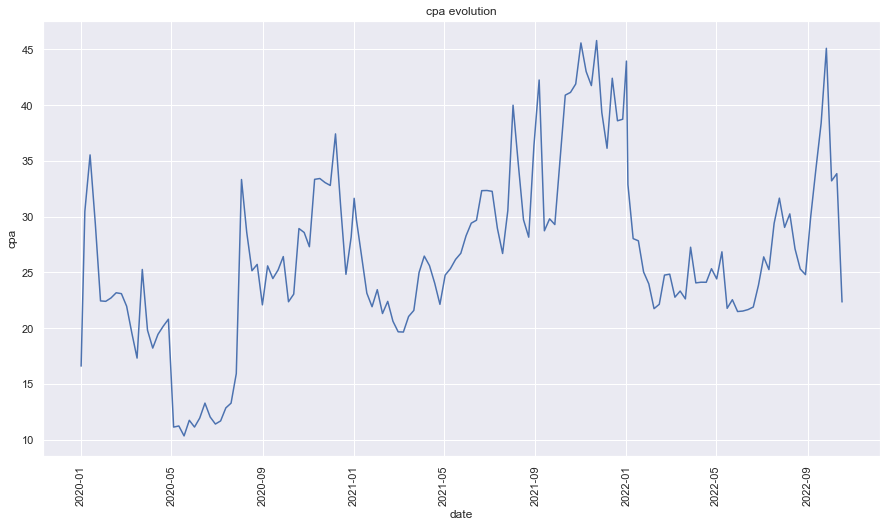

In [34]:
for y in range(2020, 2023):
    print(y, "cpa",
        round(dfglobalgp[(dfglobalgp.woy<43)&(dfglobalgp.conv_seg==True)&(dfglobalgp.year == y)].cost.sum()/
        dfglobalgp[(dfglobalgp.woy<43)&(dfglobalgp.conv_seg==True)&(dfglobalgp.year == y)].conv.sum(),2),
        "cost", dfglobalgp[(dfglobalgp.woy<43)&(dfglobalgp.conv_seg==True)&(dfglobalgp.year == y)].cost.sum(),
        "conv", dfglobalgp[(dfglobalgp.woy<43)&(dfglobalgp.conv_seg==True)&(dfglobalgp.year == y)].conv.sum()
          
    )

plot_global(dfglobalgp[dfglobalgp.conv_seg==True])

# correlation

In [ ]:
df_all_gp["mode_float"] = (df_all_gp["auto_allocation_mode"]=='true').astype(float)
df_old_gp["mode_float"] = (df_old_gp["auto_allocation_mode"]=='true').astype(float)

In [ ]:
df_all_gp[["cpa","cpa_flg","cpj", "cpj_flg" ,"board_share","mode_float"]].corr()

In [ ]:
df_old_gp[["cpa","cpa_flg","cpj", "cpj_flg", "board_share" ,"mode_float"]].corr()

## interpr

In [ ]:
df_all_gp = df_all[
["woy", "board_group","job_count","conversions","cost",
    "jb_count_flg","conv_flg","cost_flg"
]
].groupby(["board_group",  "woy"]).sum().reset_index().sort_values(["board_group", "woy"])
df_all_gp["cpa"] = df_all_gp["cost"] / df_all_gp["conversions"]
df_all_gp["cpj"] = df_all_gp["cost"] / df_all_gp["job_count"]
df_all_gp["cpa_flg"] = df_all_gp["cost_flg"] / df_all_gp["conv_flg"]
df_all_gp["cpj_flg"] = df_all_gp["cost_flg"] / df_all_gp["jb_count_flg"]
df_all_gp["year"]=2022
# df_all_gp.to_csv("autoalloc_week.csv")

# df_old = df_mdjs_last_year.merge(df_flg_hist_w, on=["customer_id", "flight_id", "board_group", "woy"], how="left")
# df_old=df_old.merge(df_flglvl, on=["customer_id", "flight_id", "woy"])
# df_old = df_old[df_old.woy > 5].reset_index(drop=True)


# df_old.auto_allocation_mode.fillna('false', inplace=True)
# df_all.auto_allocation_mode.fillna('none', inplace=True)
df_old_gp = df_old[
["woy", "board_group","job_count","conversions","cost",
    "jb_count_flg","conv_flg","cost_flg"
]
].groupby(["board_group",  "woy"]).sum().reset_index().sort_values(["board_group", "woy"])
df_old_gp["cpa"] = df_old_gp["cost"] / df_old_gp["conversions"]
df_old_gp["cpj"] = df_old_gp["cost"] / df_old_gp["job_count"]
df_old_gp["cpa_flg"] = df_old_gp["cost_flg"] / df_old_gp["conv_flg"]
df_old_gp["cpj_flg"] = df_old_gp["cost_flg"] / df_old_gp["jb_count_flg"]
df_old_gp["year"]=2021

df_all_y = pd.concat([df_old_gp, df_all_gp])

In [ ]:
b = "indeed"
px.line(df_all_y[df_all_y.board_group==b], x="woy", y="cpa_flg", color="year", title="cpa evolution")
# d = df_all_y[df_all_y.board_group==b]
# sns.lineplot(x='woy', y='cpa_flg', data=d, hue='year').set_title("cpa evolution")
# plt.show()
# d

# Date lvl

In [ ]:
# date lvl
df_all = df_mdjs.merge(df_flight_hist, on=["customer_id", "flight_id", "board_group", "date"], how="left")
df_all=df_all.merge(df_flglvl, on=["customer_id", "flight_id", "date"])
df_all = df_all[df_all.date > datetime.datetime.strptime('2022-02-06', "%Y-%m-%d").date()].reset_index(drop=True)


# df_all.auto_allocation_mode.fillna('false', inplace=True)
df_all.auto_allocation_mode.fillna('none', inplace=True)

In [ ]:
df_all[
    ["auto_allocation_mode", "date", "board_group","job_count","conversions","cost",
    "jb_count_flg","conv_flg","cost_flg"
    ]
].groupby(
    ["board_group", "auto_allocation_mode", "date"]
).sum()



In [ ]:
df_all_gp = df_all[
["auto_allocation_mode", "date", "board_group","job_count","conversions","cost",
    "jb_count_flg","conv_flg","cost_flg"
]
].groupby(["board_group", "auto_allocation_mode", "date"]).sum().reset_index().sort_values(["board_group", "date"])
df_all_gp["cpa"] = df_all_gp["cost"] / df_all_gp["conversions"]
df_all_gp["cpj"] = df_all_gp["cost"] / df_all_gp["job_count"]
df_all_gp["cpa_flg"] = df_all_gp["cost_flg"] / df_all_gp["conv_flg"]
df_all_gp["cpj_flg"] = df_all_gp["cost_flg"] / df_all_gp["jb_count_flg"]
df_all_gp.to_csv("autoalloc.csv")

In [ ]:
b = "indeed"
px.line(df_all_gp[df_all_gp.board_group==b], x="date", y="cpa_flg", color="auto_allocation_mode", title="cpa evolution")


In [ ]:
px.line(df_all_gp[df_all_gp.board_group==b], x="date", y="cost_flg", color="auto_allocation_mode")

In [ ]:
px.line(df_all_gp[df_all_gp.board_group==b], x="date", y="cpj_flg", color="auto_allocation_mode")

In [ ]:
b = "indeed"
px.line(df_all_gp[df_all_gp.board_group==b], x="date", y="cpa", color="auto_allocation_mode", title="cpa evolution")


In [ ]:

px.line(df_all_gp[df_all_gp.board_group==b], x="date", y="cost", color="auto_allocation_mode")


In [ ]:
px.line(df_all_gp[df_all_gp.board_group==b], x="date", y="cpj", color="auto_allocation_mode")

In [ ]:
px.line(df_all_gp[df_all_gp.board_group==b], x="date", y="conversions", color="auto_allocation_mode")

In [ ]:
px.line(df_all_gp[df_all_gp.board_group=="adwords"], x="date", y="cpa", color="auto_allocation_mode")

In [ ]:
df_all_gp["board_share"] = df_all_gp["cost"] / df_all_gp["cost_flg"]
px.line(df_all_gp[df_all_gp.board_group==b], x="date", y="board_share", color="auto_allocation_mode")